
## In Sample Analysis Code



In [1]:
#This code run on google colab
#here we need to install the dependencies

!pip install yfinance
!pip install arch
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#importing libraries and taking data 

import yfinance 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from datetime import datetime  
from datetime import timedelta  
import arch 
from arch.__future__ import reindexing
  
#plot settings
plt.rcParams['figure.figsize'] = [11.0, 5.0]
plt.rcParams['figure.dpi'] = 110

#retrieve data
data = yfinance.Ticker("BTC-USD")
data = data.history(period = "max")
close_price = data["Close"]
intra_day_gemini = pd.read_csv('/content/drive/MyDrive/BITCOIN DATA/gemini_new.csv')
intra_day_gemini_1h = pd.read_csv('/content/drive/MyDrive/BITCOIN DATA/Gemini_BTCUSD_1h.csv')


#calculate returns
r = np.log(close_price/close_price.shift())   #log returns
r = r.dropna()
perc_r = r*100 - r.mean()*100                 #percentage log returns

R = (close_price/close_price.shift()) - 1     #simple returns

#example of a model
garch11_t = arch.arch_model(perc_r, p = 1, q = 1, dist = "Normal")
m_fit = garch11_t.fit(update_freq=5)
print("\n\n\n", m_fit.summary())

Iteration:      5,   Func. Count:     36,   Neg. LLF: 7671.751145958768
Iteration:     10,   Func. Count:     70,   Neg. LLF: 7668.209693520076
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7668.207005044398
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12



                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7668.21
Distribution:                  Normal   AIC:                           15344.4
Method:            Maximum Likelihood   BIC:                           15368.2
                                        No. Observations:                 2832
Date:                Sun, Jun 19 2022   Df Residuals:                     2831
Time:     

In [3]:
#calculating the realized volatility 
def intra_day_vol_gem(dataset):
    names = dataset.columns.to_list()
    for j in range(len(names)):
      names[j] = names[j].lower()

    dataset.columns = names 
    dataset['date'] = pd.to_datetime(dataset['date'])
    dataset = dataset.set_index(dataset.date)
    dataset = dataset.assign(ret = 100 * np.log(dataset.close.shift(1) / dataset.close))
    
    def real_vol(s):
        r_2 = (s-s.mean())**2
        n = 1
        return np.sqrt(r_2.sum()/n)

    real_vol = dataset.ret.resample("D").apply(real_vol)
    return real_vol 

gemini_1m = intra_day_vol_gem(intra_day_gemini)
gemini_1h = intra_day_vol_gem(intra_day_gemini_1h)

In [4]:
from datetime import timedelta  

#function created to get the precedent date given a date 
def  get_precedent(date_list):
      prec_date = []
      for j in date_list:
        prec_date.append(j - timedelta(days=1) )
      return prec_date


#remove two outliers from the gemini series of volatility needed for minute data 
#we remove the n-largest observation, and put a lower bound for volatility to remove the observation that are 0, or small 

def remove_outliers(data, n, *low_bound):
    
    #removing outliers : large values 
    index_to_remove = data.nlargest(n).index
    prec_index = get_precedent(index_to_remove)
    gemini_to_sub = data.loc[data.index.isin(prec_index)]
    res = data.copy()
    res.loc[data.index.isin(index_to_remove)] = gemini_to_sub.values
    
    #if low_bound we take values from the past gradually 
    #if we found index that correspond to values smaller than low bound we take the previous 
    c = 0 
    if low_bound:
        while (res <= low_bound ).sum() != 0:                           
          index_zero = (res.iloc[(res <= low_bound ).values]).index
          prec = get_precedent(index_zero)
          gemini_to_sub = res.loc[res.index.isin(prec)]
          res.loc[data.index.isin(index_zero)] = gemini_to_sub.values
          c += 1
          
    return res


def MAE(fitted, real):
    abs_series = (fitted-real).abs()
    return abs_series.mean()

def MSE(fitted, real):
    square_series = (fitted-real).pow(2)
    return square_series.mean()



In [5]:
#define train sets
train_set = perc_r.loc[perc_r.index < "2021-01-01"]
train_real = gemini_1m.loc[gemini_1m.index < "2021-01-01"]
train_real_1h = gemini_1h.loc[gemini_1h.index < "2021-01-01"]

n_obs_to_avoid = 2


#visualize the fitting of a model on conditional realized volatility
def visual(fit, n_out = n_obs_to_avoid):
    gem_index = train_real.index            #implement to take data till last date     
    fitted_garch = fit.conditional_volatility.loc[(m_fit.conditional_volatility).notnull()]
    fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
    plt.plot(remove_outliers(train_real,2))
    plt.plot(fitted_garch, label = "Fitted")
    loss_text = f"INTRADAY:  MSE: {MSE(fitted_garch, remove_outliers(train_real,2))}  MAE: {MAE(fitted_garch, remove_outliers(train_real,2))}"
    plt.legend()
    plt.title(loss_text)
    plt.show()


#function to plot the heatmap 
def heat(data, distribution, function_model):
    p = [i for i in range(6,0,-1)]
    q = [j for j in range(1,7)]
    aic_heat = pd.DataFrame(index = p, columns = q, dtype="float")
    bic_heat = pd.DataFrame(index = p, columns = q, dtype="float")

    aic_heat.index = aic_heat.index.rename("p")
    aic_heat.columns = aic_heat.columns.rename("q")

    bic_heat.index = bic_heat.index.rename("p")
    bic_heat.columns = bic_heat.columns.rename("q")
    
    for p_par in p:
        for q_par in q:
            fitted = function_model(data, p_par, q_par, distribution)
            aic_heat.loc[p_par, q_par] = fitted[0]
            bic_heat.loc[p_par, q_par] = fitted[1]
                                                  

    sb.heatmap(aic_heat, cmap="YlGnBu", robust = True, square = False)
    plt.title(f"AIC - {distribution}")
    plt.show()        
    sb.heatmap(bic_heat, cmap="YlGnBu", robust = True, square = False)
    plt.title(f"BIC - {distribution}")
    plt.show()

    m_aic = aic_heat.min().min()
    m_bic = bic_heat.min().min()

    return [aic_heat.where(aic_heat == m_aic).dropna(how="all").dropna(axis=1).index.values.item() , aic_heat.where(aic_heat == m_aic).dropna(how="all").dropna(axis=1).columns.values.item()], [bic_heat.where(bic_heat == m_bic).dropna(how="all").dropna(axis=1).index.values.item() , aic_heat.where(bic_heat == m_bic).dropna(how="all").dropna(axis=1).columns.values.item()]



#function to observe realized versus fitted 

def observe_fitted_realized(fit_model, perc_r,vol = True):   #vol is volatility 
    if not vol:  #variance
        gem_index = train_real.index            #implement to take data till last date     
        fitted_garch = fit_model.conditional_volatility.loc[(fit_model.conditional_volatility).notnull()]
        fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
        real = (train_set.loc[(train_set.index.isin(gem_index))])**2

        plt.plot(real, label = "Realized")
        plt.plot(fitted_garch**2, label = "Fitted")
        plt.legend()
        plt.title(f"PROXY:   MSE: {MSE(real, fitted_garch**2)} MAE: {MAE(real, fitted_garch**2)}")
        plt.show()


    else:
      #volatility
        gem_index = train_real.index            #implement to take data till last date     
        fitted_garch = fit_model.conditional_volatility.loc[(fit_model.conditional_volatility).notnull()]
        fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
        real = train_set.loc[(train_set.index.isin(gem_index))].abs()
        plt.plot(real, label = "Realized")
        plt.plot(fitted_garch, label = "Fitted")
        plt.legend()
        plt.title(f"PROXY:   MSE: {MSE(real, fitted_garch)} MAE: {MAE(real, fitted_garch)}")
        plt.show()



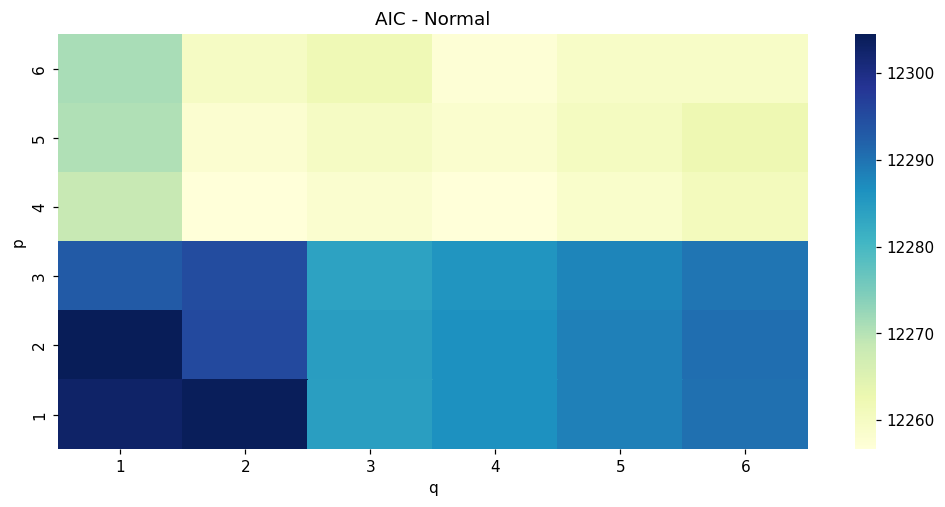

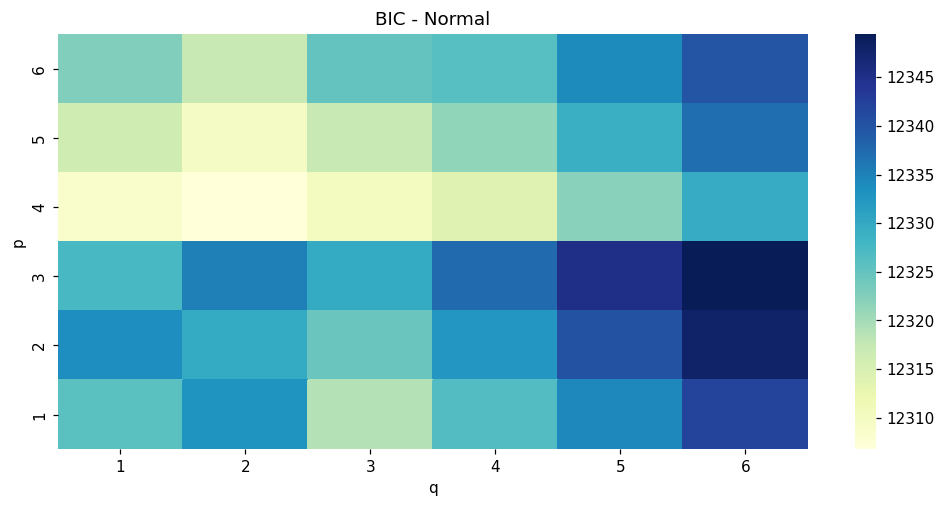

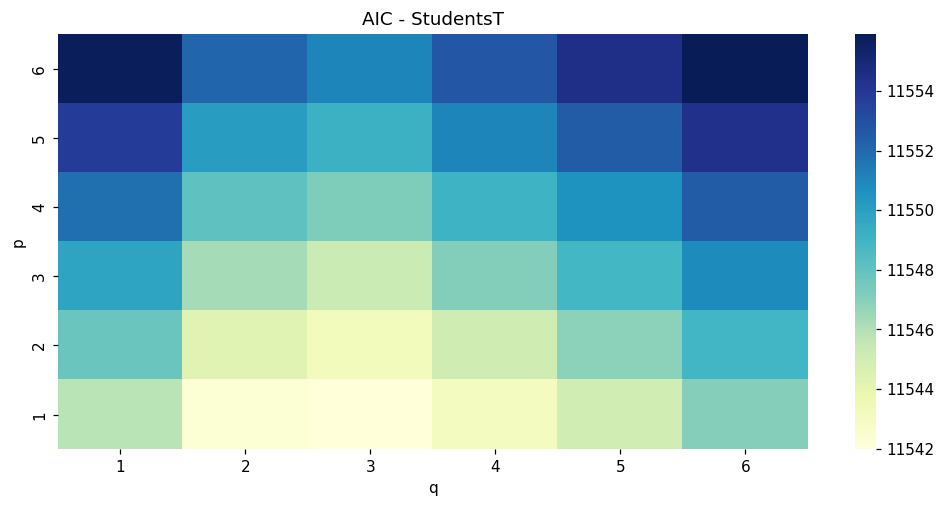

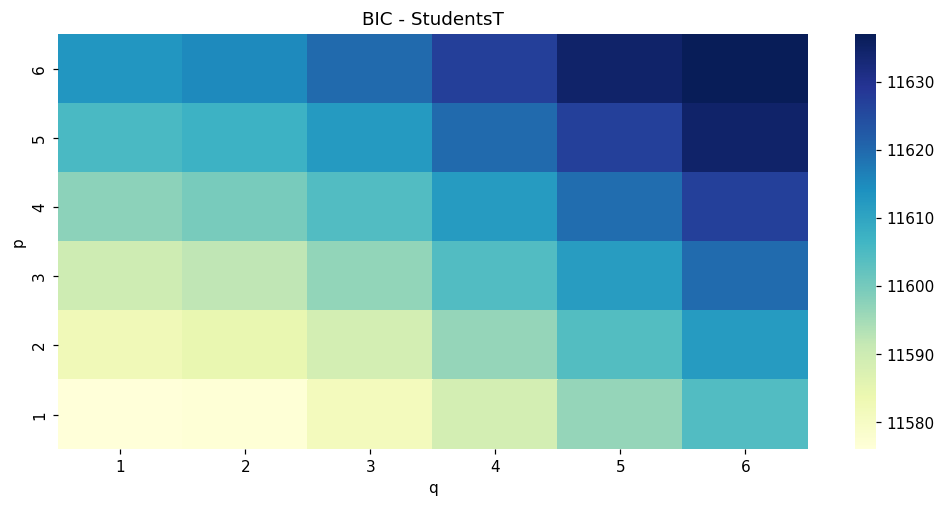

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


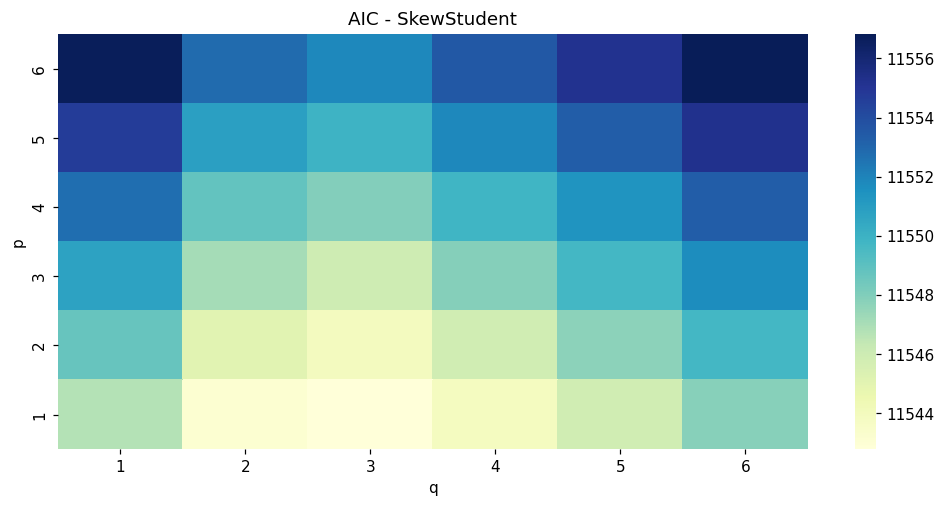

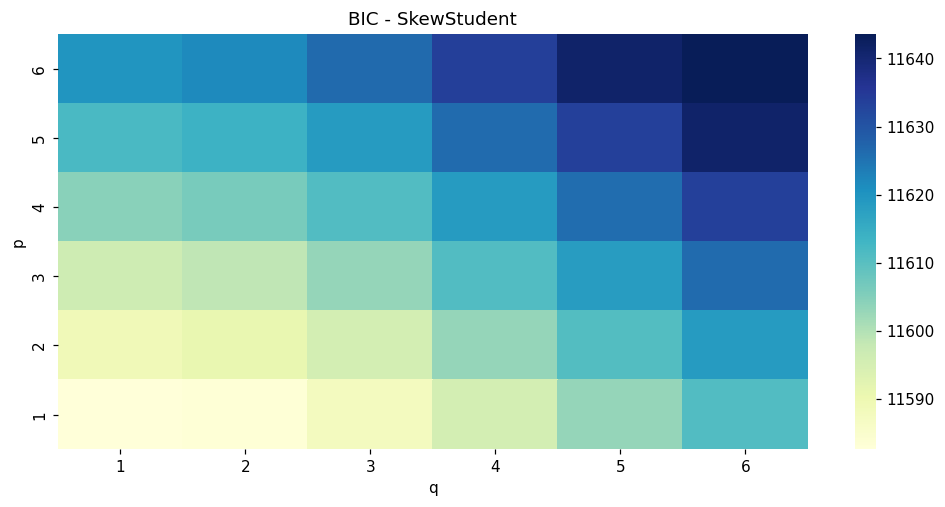



Normal distribution:  AIC choose [4, 2], BIC choose [4, 2]
Student distribution:  AIC choose [1, 3], BIC choose [1, 1]
Skew Student distribution:  AIC choose [1, 3], BIC choose [1, 1]


In [6]:
############################ G A R C H ######################################

#this function reutns aic and bic for a GARCH model
def info_garch(data, p,q, distribution):
    garch = arch.arch_model(data, p = p, q = q, dist = distribution)
    fit = garch.fit(update_freq=0, disp="off")
    return fit.aic, fit.bic

#create heat maps for GARCH models
aic_norm, bic_norm = heat(train_set,"Normal", info_garch)
aic_stud, bic_stud = heat(train_set,"StudentsT", info_garch)
aic_skewt, bic_skewt = heat(train_set, "SkewStudent", info_garch)

print(f"\n\nNormal distribution:  AIC choose {aic_norm}, BIC choose {bic_norm}")
print(f"Student distribution:  AIC choose {aic_stud}, BIC choose {bic_stud}")
print(f"Skew Student distribution:  AIC choose {aic_skewt}, BIC choose {bic_skewt}")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6120.16
Distribution:                  Normal   AIC:                           12256.3
Method:            Maximum Likelihood   BIC:                           12302.2
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:54:46   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0402  6.119e-02      0.657      0.511 [-7.97

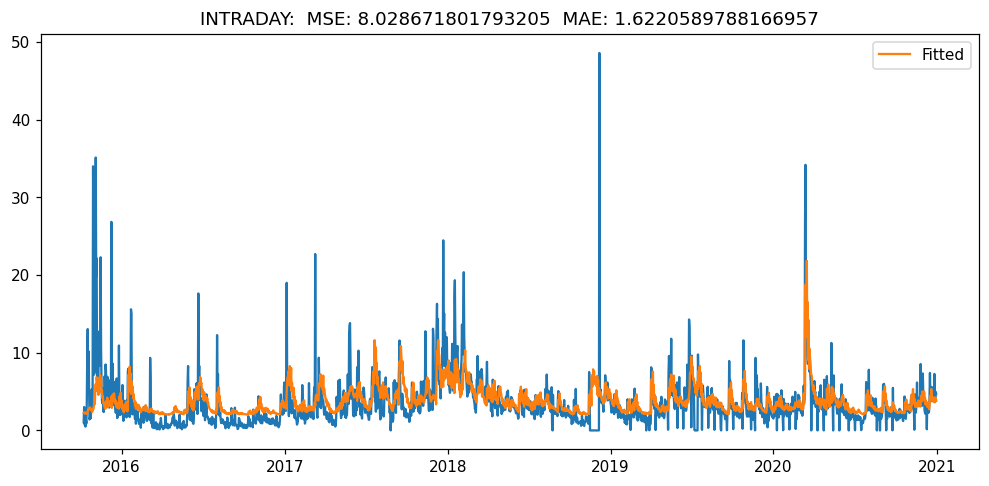

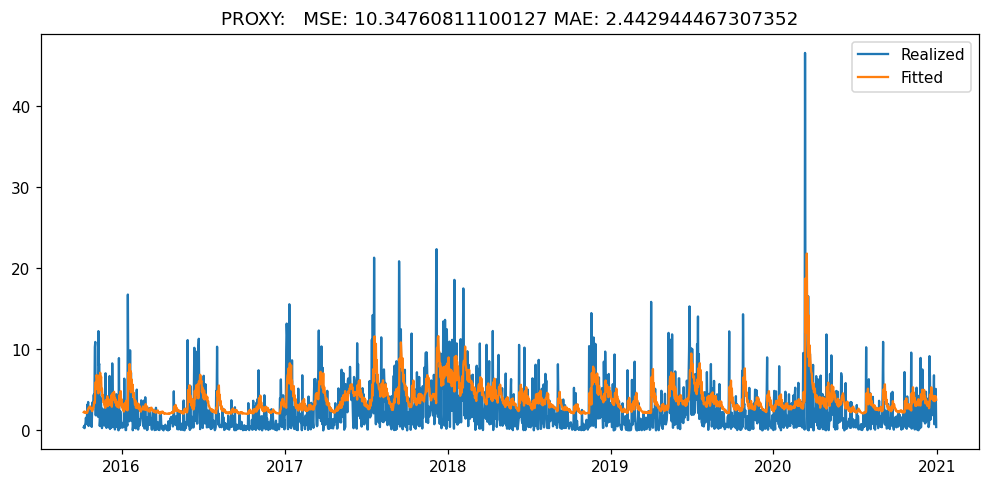

In [7]:
#confronting the models given by the normal distribution

#both AIC and BIC choose [4,2]
garch_42 = arch.arch_model(train_set, p = 4, q = 2 , dist = "Normal")
garch_42_fit = garch_42.fit(update_freq=0, disp="off")
print(garch_42_fit.summary())
visual(garch_42_fit)
observe_fitted_realized(garch_42_fit, train_set, True)

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5763.62
Distribution:      Standardized Student's t   AIC:                           11541.2
Method:                  Maximum Likelihood   BIC:                           11581.4
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:54:46   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

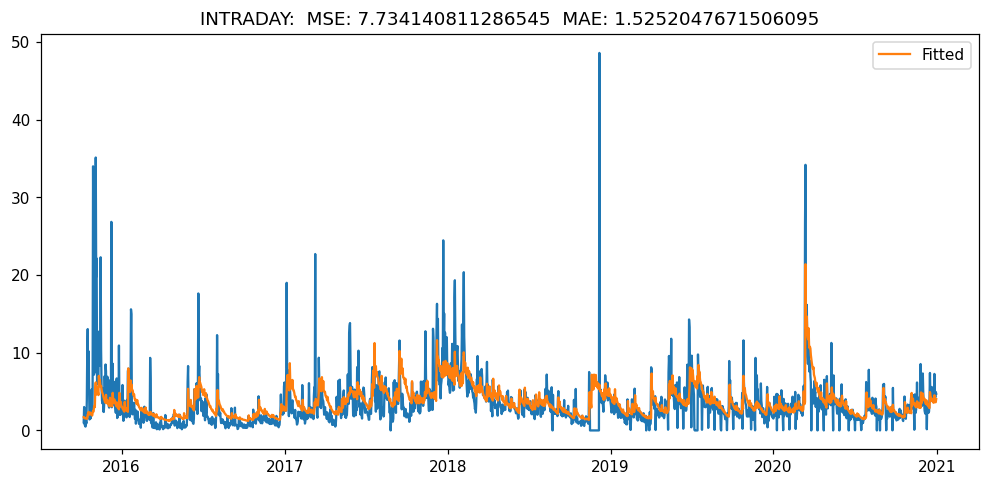

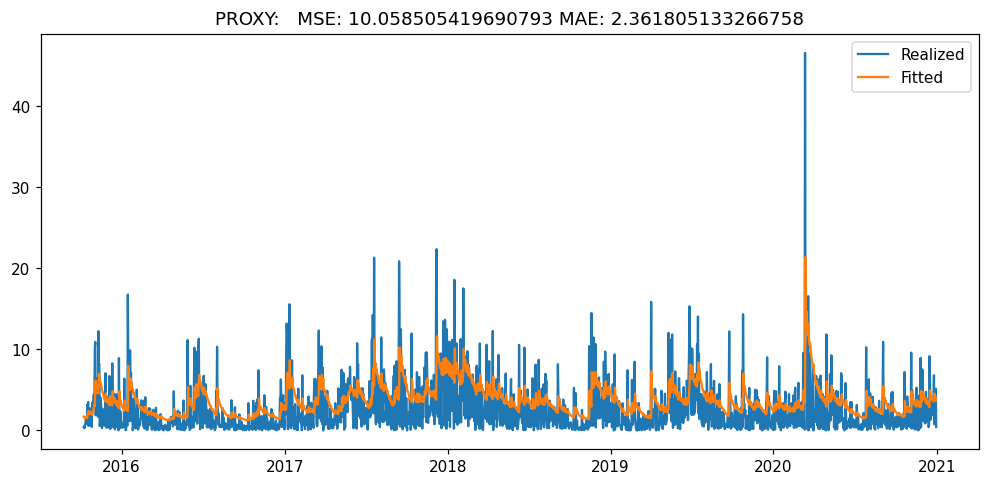

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5767.91
Distribution:      Standardized Student's t   AIC:                           11545.8
Method:                  Maximum Likelihood   BIC:                           11574.5
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:54:47   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

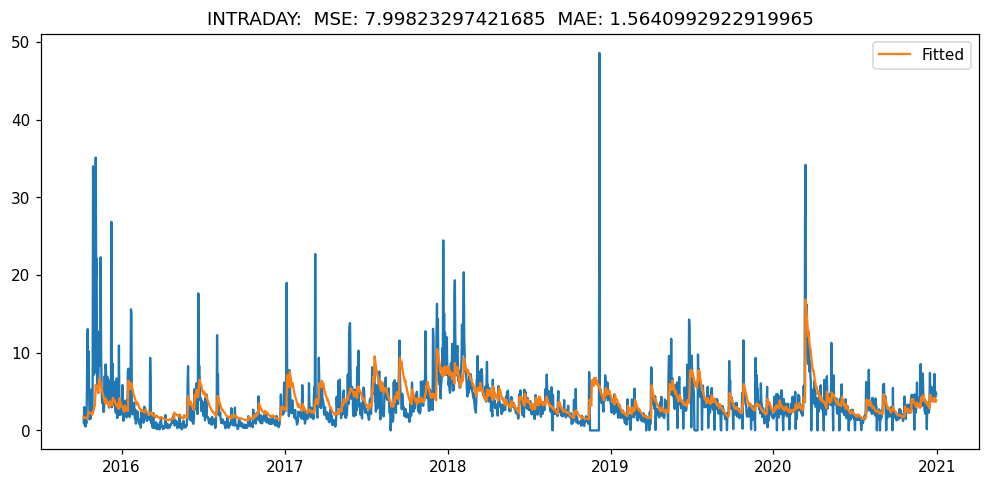

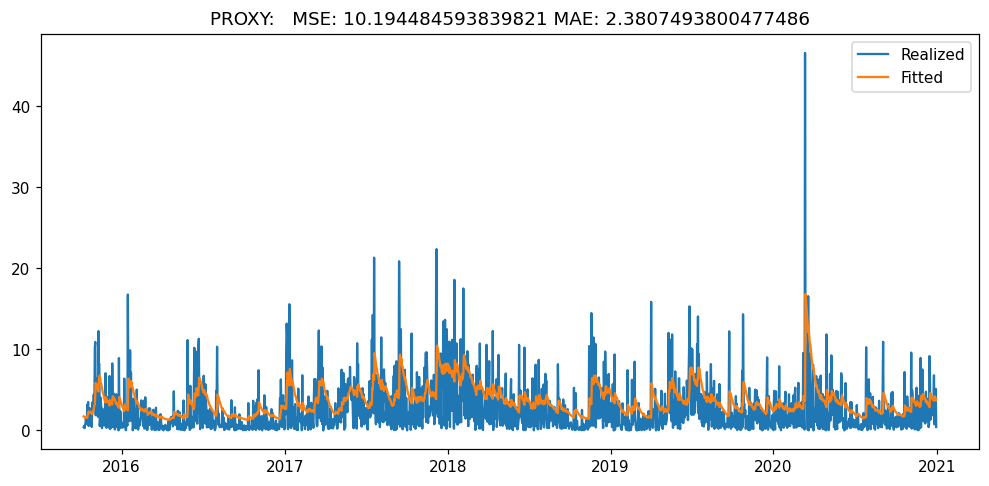

In [8]:
#confronting the models given by the StudentsT distribution 

#AIC chooses [1,3]
garch_13 = arch.arch_model(train_set, p = 1, q = 3, dist = "StudentsT")
garch_13_fit = garch_13.fit(update_freq=0, disp="off")
print(garch_13_fit.summary())
visual(garch_13_fit)
observe_fitted_realized(garch_13_fit, train_set, True)

#BIC chooses [1,1]
garch_11 = arch.arch_model(train_set, p = 1, q = 1, dist = "StudentsT")
garch_11_fit = garch_11.fit(update_freq=0, disp="off")
print(garch_11_fit.summary())
visual(garch_11_fit)
observe_fitted_realized(garch_11_fit, train_set, True)


                           Constant Mean - GARCH Model Results                           
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -5762.99
Distribution:      Standardized Skew Student's t   AIC:                           11542.0
Method:                       Maximum Likelihood   BIC:                           11587.9
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:54:48   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

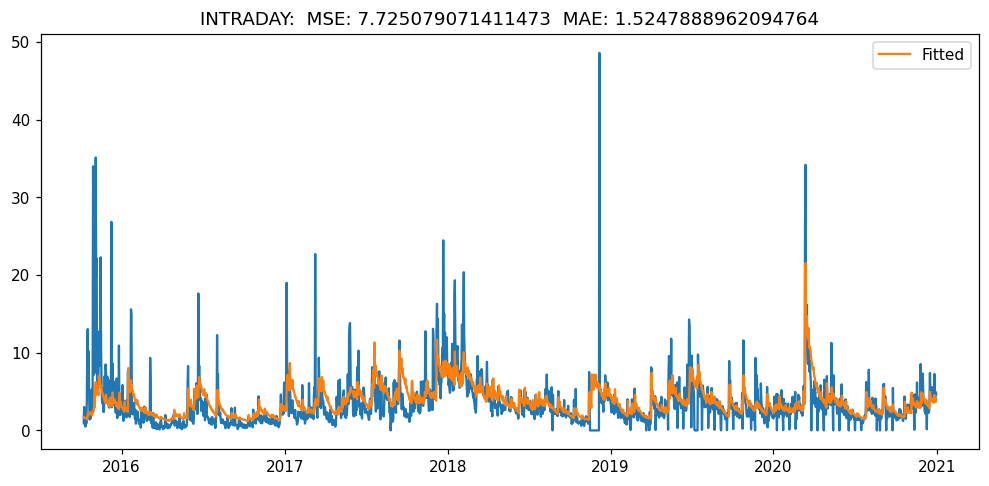

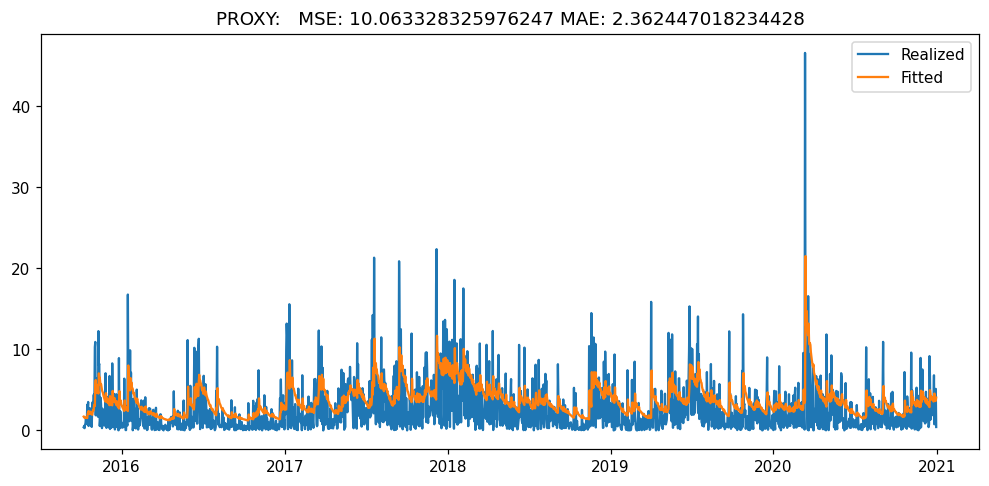

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -5767.37
Distribution:      Standardized Skew Student's t   AIC:                           11546.7
Method:                       Maximum Likelihood   BIC:                           11581.2
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:54:49   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

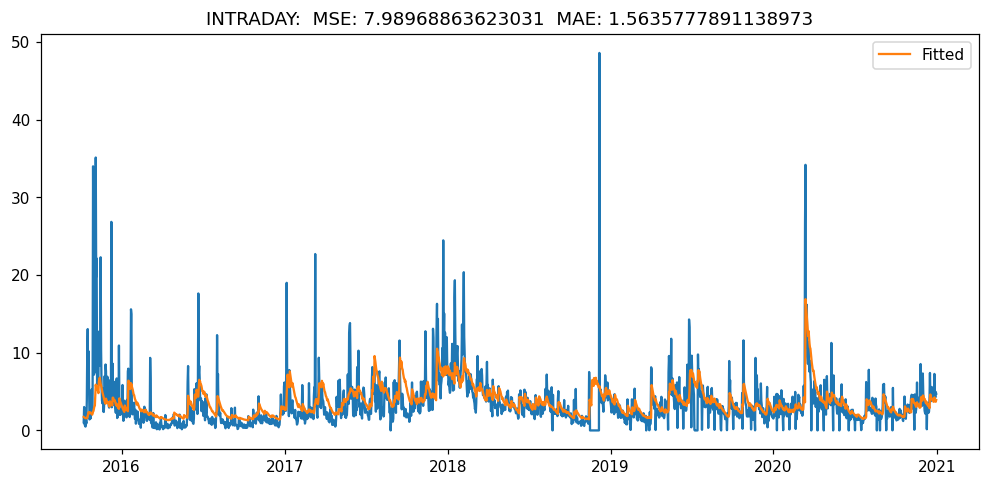

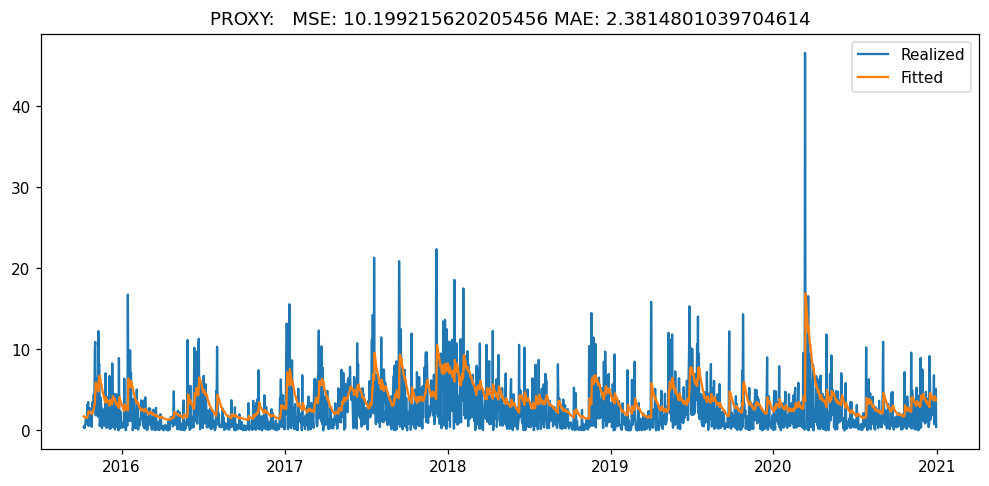

In [9]:
#confronting the models given by the skewStudent distribution 

#AIC chooses [1,3]
garch_13_ss = arch.arch_model(train_set, p = 1, q = 3, dist = "skewStudent")
garch_13_fit_ss = garch_13_ss.fit(update_freq=0, disp="off")
print(garch_13_fit_ss.summary())
visual(garch_13_fit_ss)
observe_fitted_realized(garch_13_fit_ss, train_set, True)

#BIC chooses [1,1]
garch_11_ss = arch.arch_model(train_set, p = 1, q = 1, dist = "skewStudent")
garch_11_fit_ss = garch_11_ss.fit(update_freq=0, disp="off")
print(garch_11_fit_ss.summary())
visual(garch_11_fit_ss)
observe_fitted_realized(garch_11_fit_ss, train_set, True)

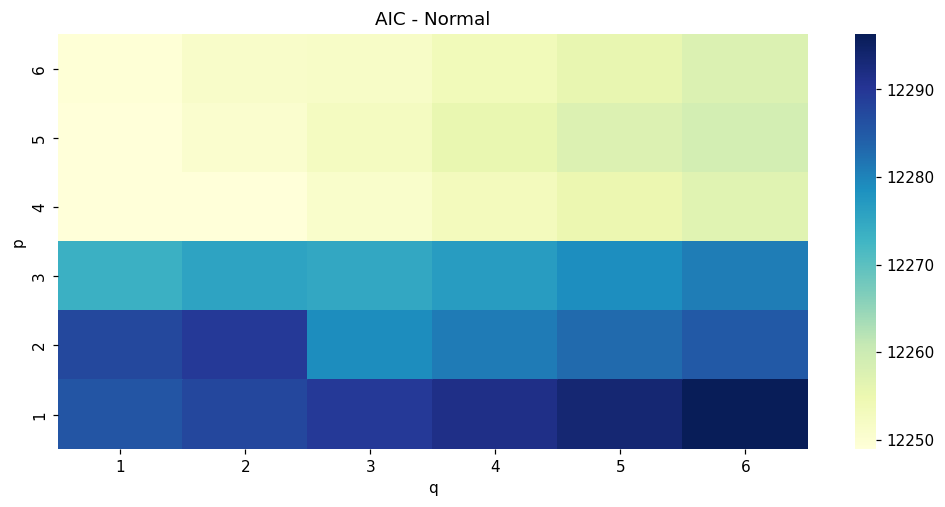

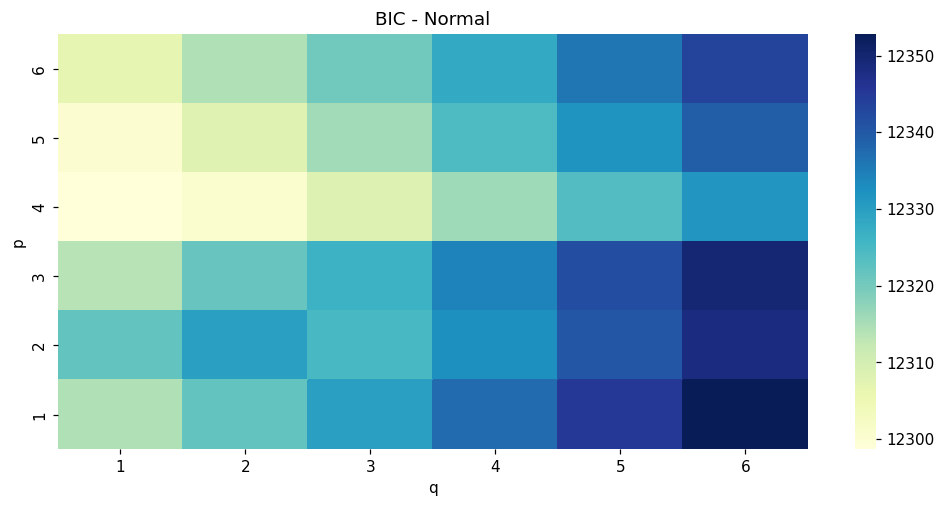

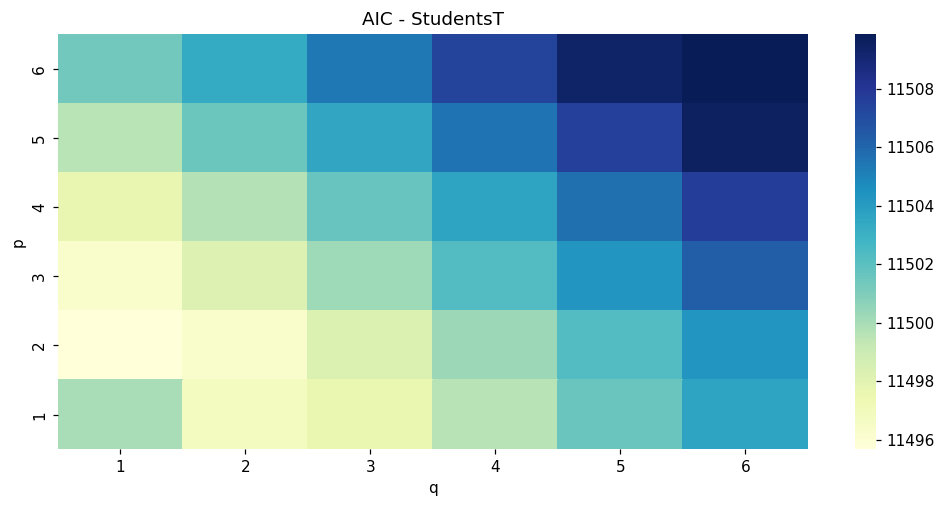

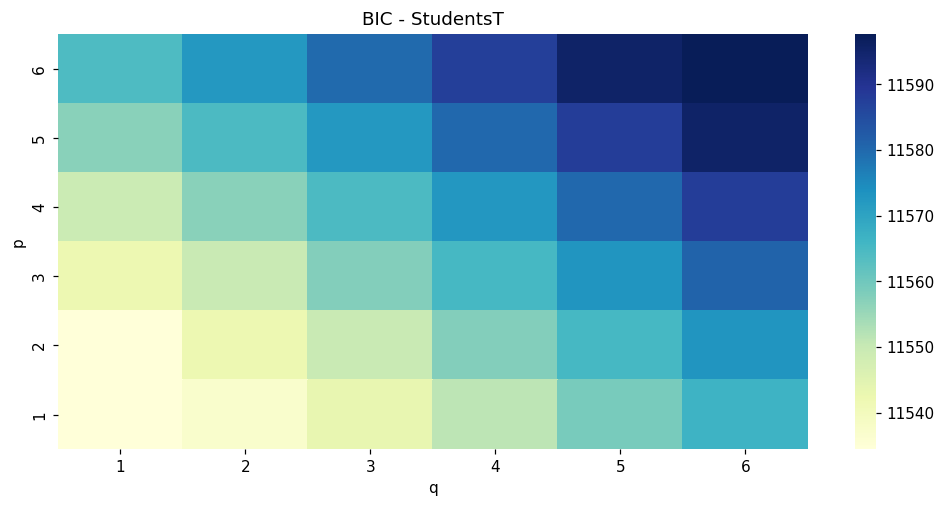

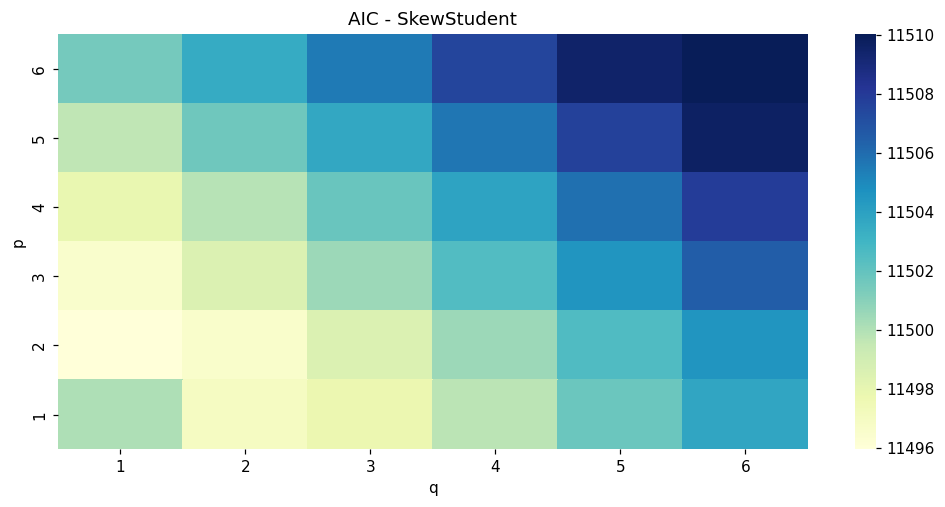

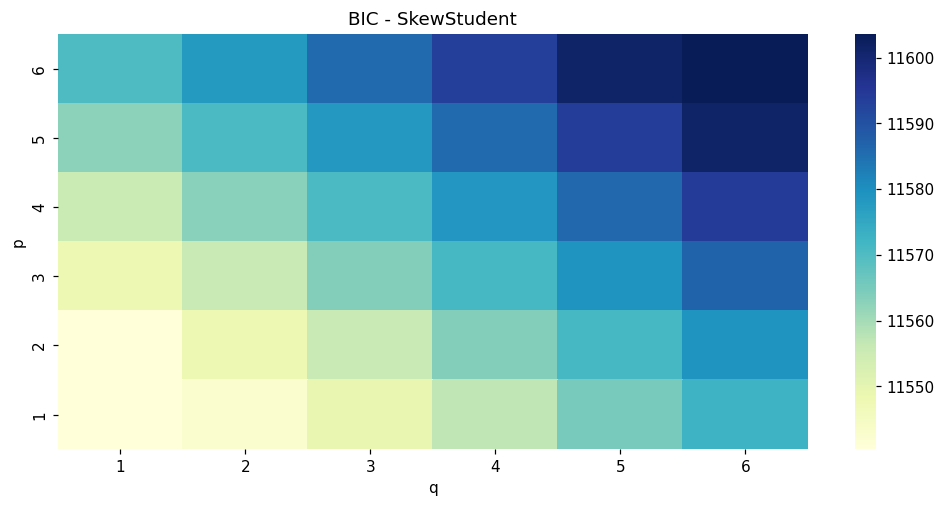



Normal distribution:  AIC choose [5, 1], BIC choose [4, 1]
Student distribution:  AIC choose [2, 1], BIC choose [1, 1]
Skew Student distribution:  AIC choose [2, 1], BIC choose [1, 1]


In [10]:
############################ E - G A R C H ######################################

#this function reutns aic and bic for a E-GARCH model
def info_e_garch(data, p, q, distribution):
    garch = arch.arch_model(data, vol = "EGARCH", p = p, o = 1, q = q, dist = distribution)
    fit = garch.fit(update_freq=0, disp="off")
    return fit.aic, fit.bic

aic_norm, bic_norm = heat(train_set,"Normal", info_e_garch)
aic_stud, bic_stud = heat(train_set,"StudentsT", info_e_garch)
aic_skewt, bic_skewt = heat(train_set, "SkewStudent", info_e_garch)

print(f"\n\nNormal distribution:  AIC choose {aic_norm}, BIC choose {bic_norm}")
print(f"Student distribution:  AIC choose {aic_stud}, BIC choose {bic_stud}")
print(f"Skew Student distribution:  AIC choose {aic_skewt}, BIC choose {bic_skewt}")

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6115.31
Distribution:                  Normal   AIC:                           12248.6
Method:            Maximum Likelihood   BIC:                           12300.3
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:55:16   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0575  1.723e-03    -33.395 1.615e-2

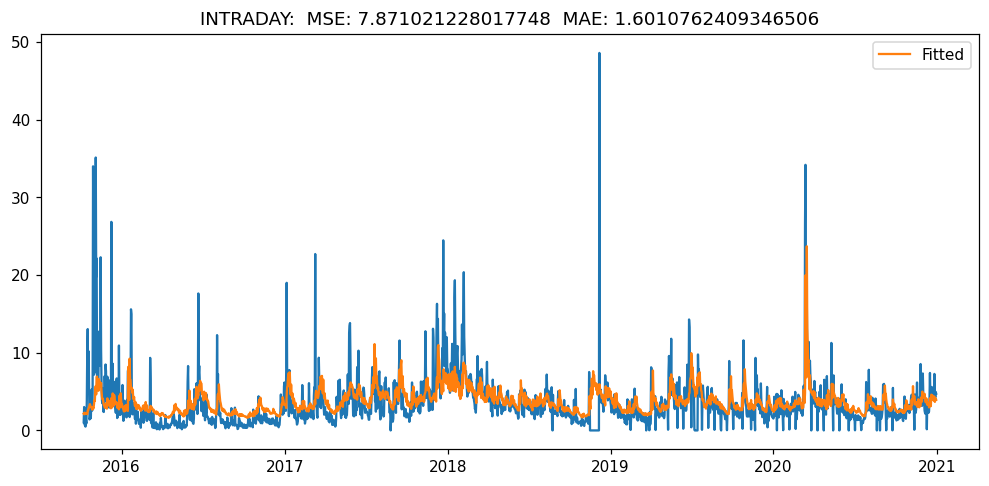

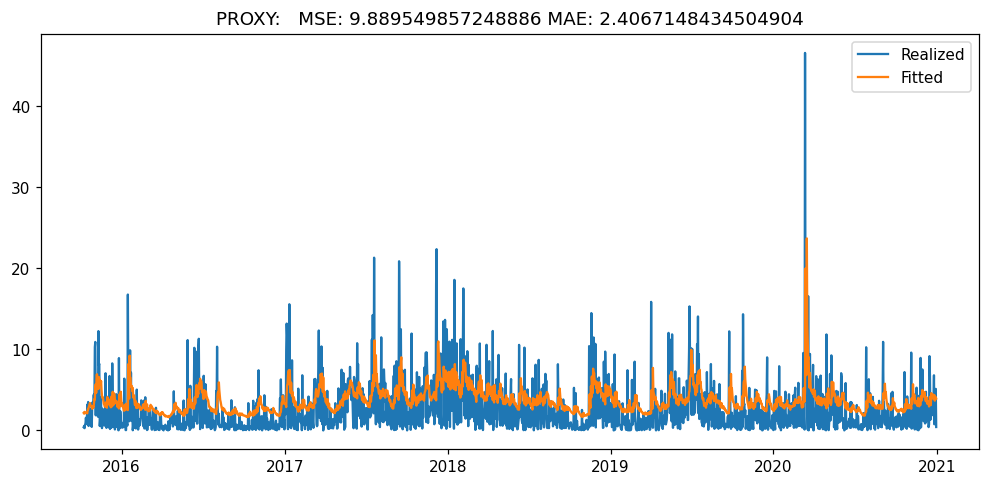

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6116.52
Distribution:                  Normal   AIC:                           12249.0
Method:            Maximum Likelihood   BIC:                           12295.0
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:55:17   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0150  9.359e-02     -0.160      0.873 [ -0.198,  0.16

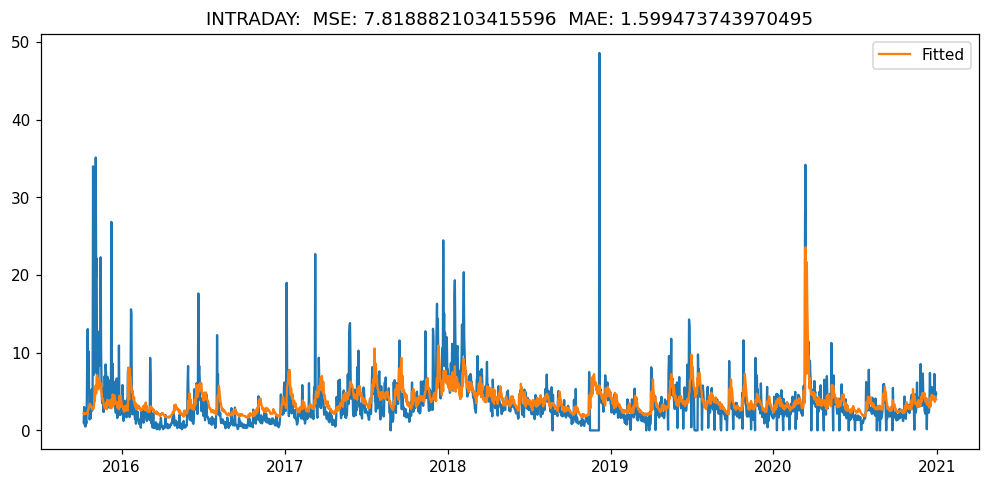

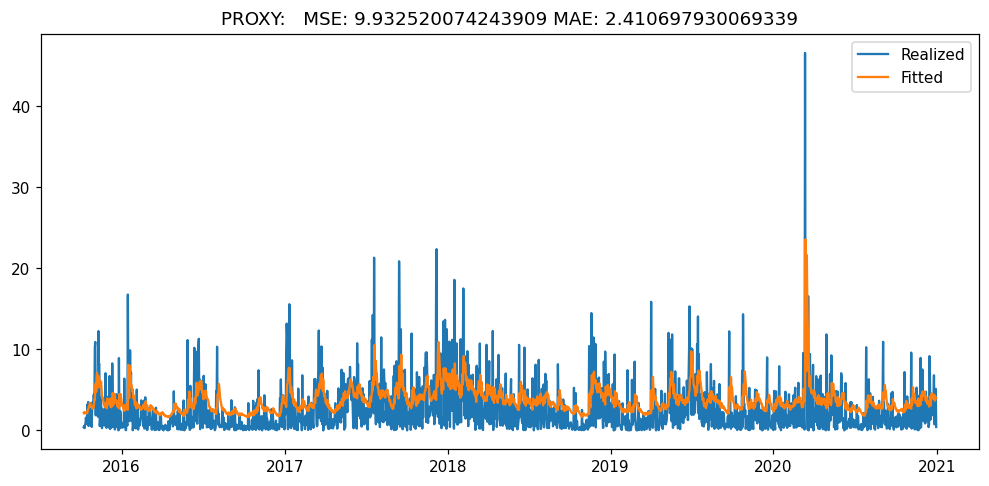

In [11]:
#confronting the models given by the normal distribution

#AIC chooses [5,1]
e_garch_51 = arch.arch_model(train_set, vol = "EGARCH", p = 5, o=1, q = 1 , dist = "Normal")
e_garch_51_fit = e_garch_51.fit(update_freq=0, disp="off")
print(e_garch_51_fit.summary())
visual(e_garch_51_fit)
observe_fitted_realized(e_garch_51_fit, train_set, True)

#BIC chooses [4,1]
e_garch_41 = arch.arch_model(train_set, vol = "EGARCH", p = 4, o=1, q = 1 , dist = "Normal")
e_garch_41_fit = e_garch_41.fit(update_freq=0, disp="off")
print(e_garch_41_fit.summary())
visual(e_garch_41_fit)
observe_fitted_realized(e_garch_41_fit, train_set, True)

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5740.14
Distribution:      Standardized Student's t   AIC:                           11494.3
Method:                  Maximum Likelihood   BIC:                           11534.5
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:55:18   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

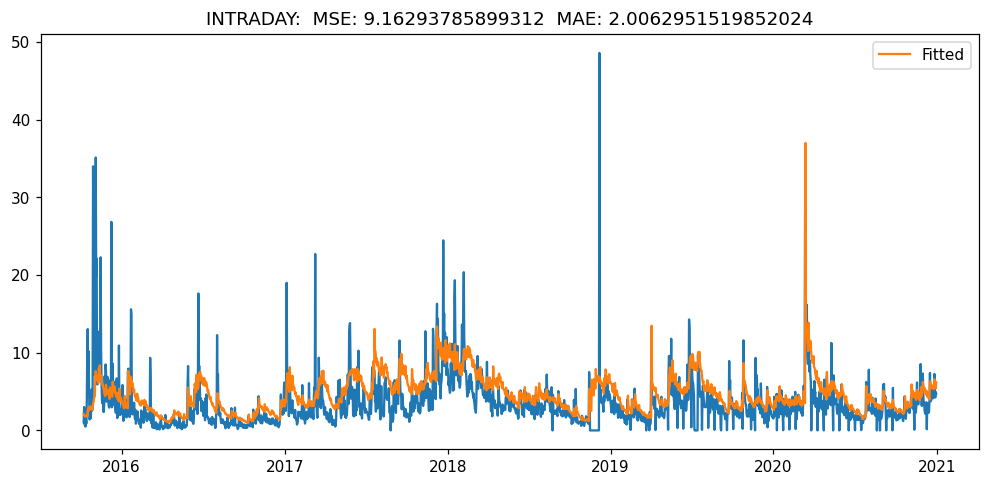

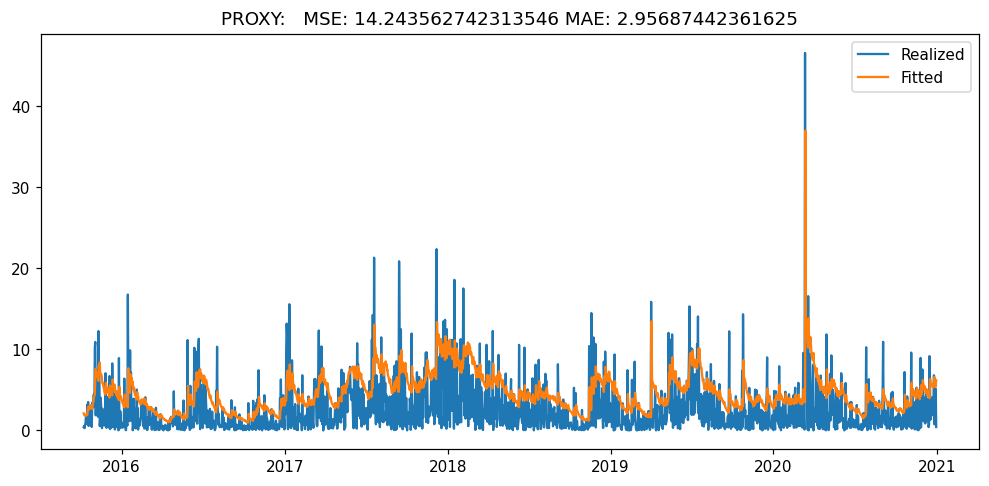

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -5743.98
Distribution:      Standardized Student's t   AIC:                           11500.0
Method:                  Maximum Likelihood   BIC:                           11534.4
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:55:18   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

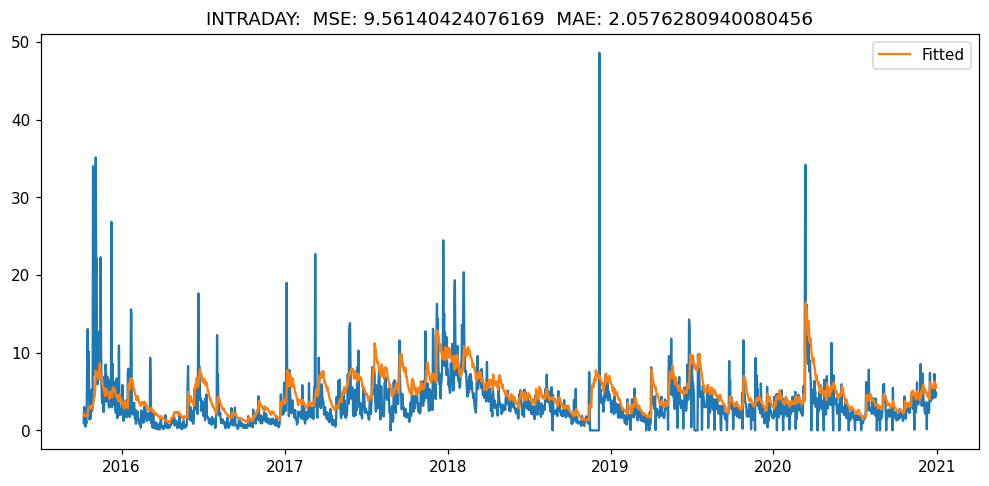

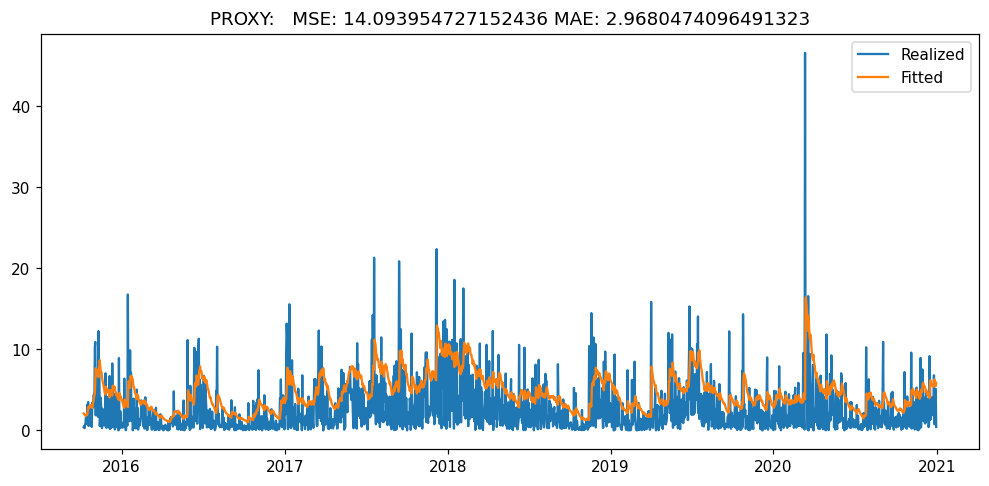

In [12]:
#confronting the models given by the StudentsT distribution 

#AIC chooses [2,1]
e_garch_21 = arch.arch_model(train_set, vol = "EGARCH", p = 2, o=1, q = 1 , dist = "StudentsT")
e_garch_21_fit = e_garch_21.fit(update_freq=0, disp="off")
print(e_garch_21_fit.summary())
visual(e_garch_21_fit)
observe_fitted_realized(e_garch_21_fit, train_set, True)

#BIC chooses [1,1]
e_garch_11 = arch.arch_model(train_set, vol = "EGARCH", p = 1, o=1, q = 1 , dist = "StudentsT")
e_garch_11_fit = e_garch_11.fit(update_freq=0, disp="off")
print(e_garch_11_fit.summary())
visual(e_garch_11_fit)
observe_fitted_realized(e_garch_11_fit, train_set, True)

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -5739.29
Distribution:      Standardized Skew Student's t   AIC:                           11494.6
Method:                       Maximum Likelihood   BIC:                           11540.5
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:55:19   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

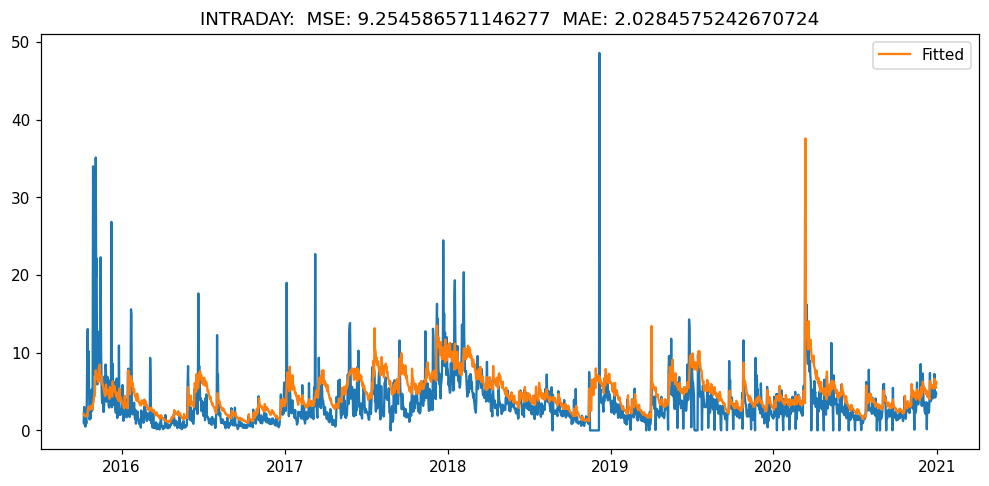

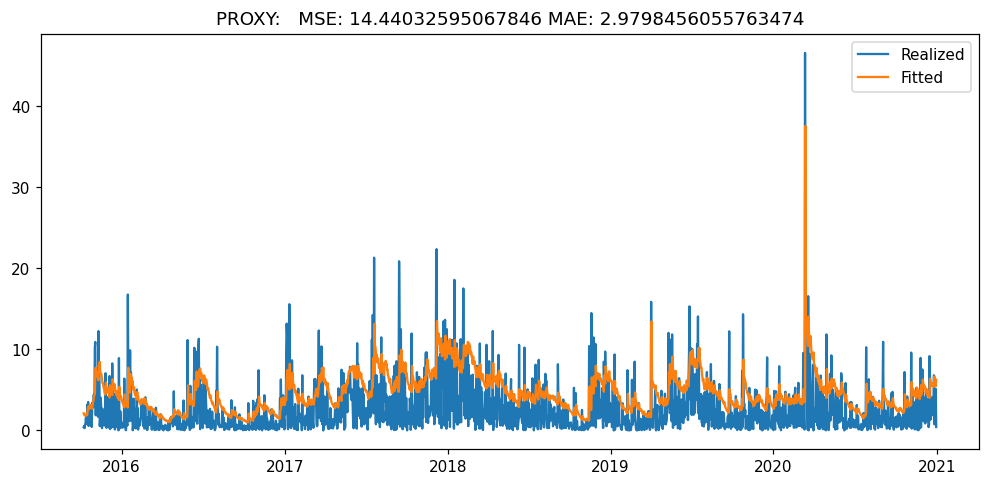

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -5743.07
Distribution:      Standardized Skew Student's t   AIC:                           11500.1
Method:                       Maximum Likelihood   BIC:                           11540.3
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:55:20   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------

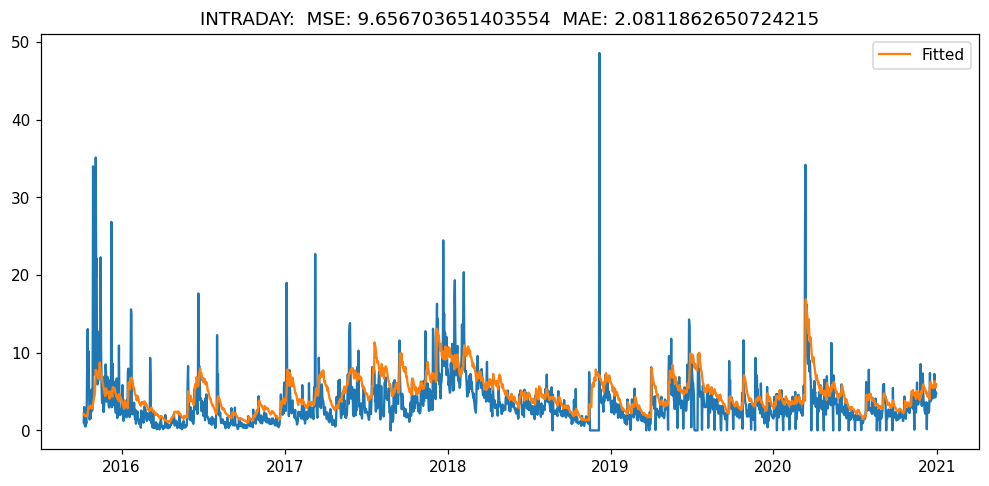

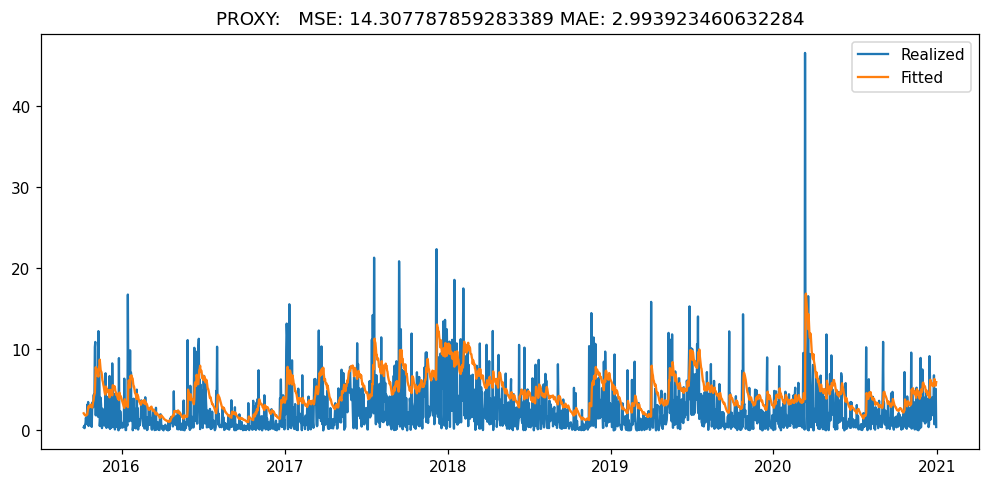

In [13]:
#confronting the models given by the SkewStudent distribution 

#AIC chooses [2,1]
e_garch_21 = arch.arch_model(train_set, vol = "EGARCH", p = 2, o=1, q = 1 , dist = "SkewStudent")
e_garch_21_fit_ss = e_garch_21.fit(update_freq=0, disp="off")
print(e_garch_21_fit_ss.summary())
visual(e_garch_21_fit_ss)
observe_fitted_realized(e_garch_21_fit_ss, train_set, True)

#BIC chooses [1,1]
e_garch_11 = arch.arch_model(train_set, vol = "EGARCH", p = 1, o=1, q = 1 , dist = "SkewStudent")
e_garch_11_fit_ss = e_garch_11.fit(update_freq=0, disp="off")
print(e_garch_11_fit_ss.summary())
visual(e_garch_11_fit_ss)
observe_fitted_realized(e_garch_11_fit_ss, train_set, True)

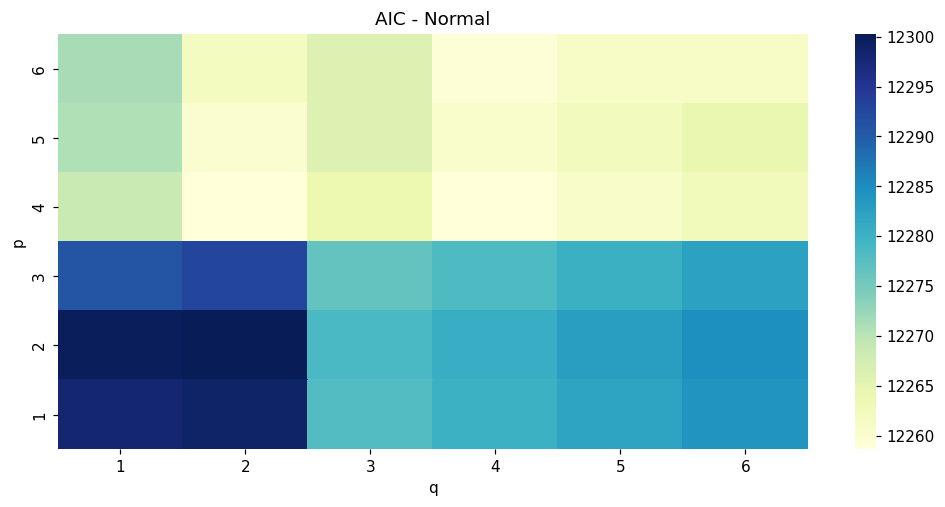

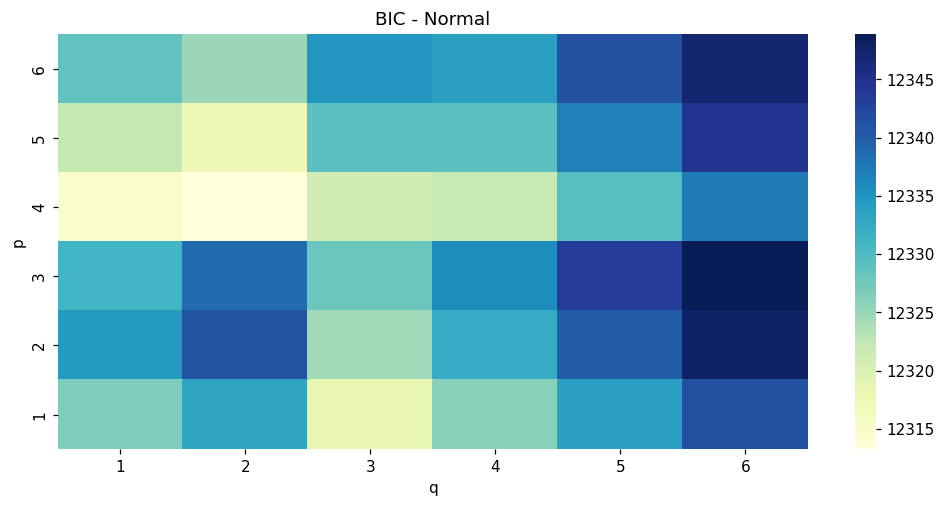

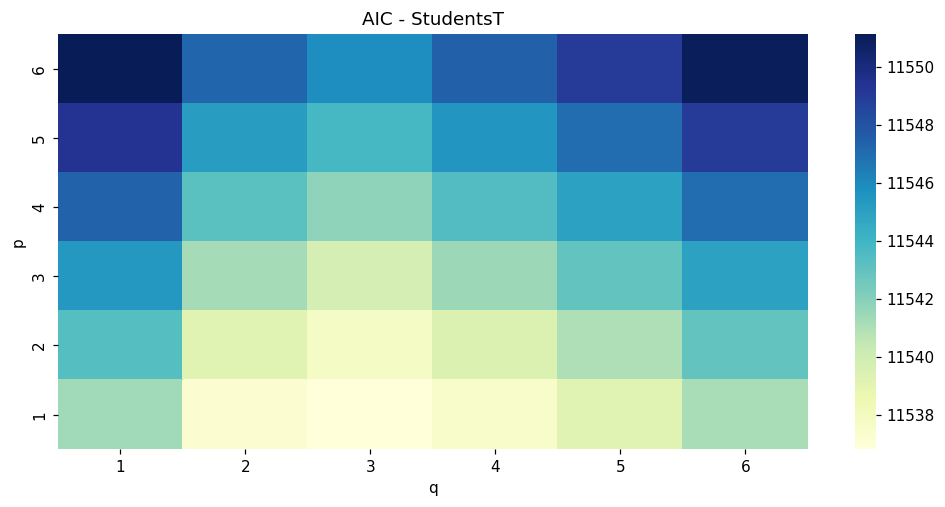

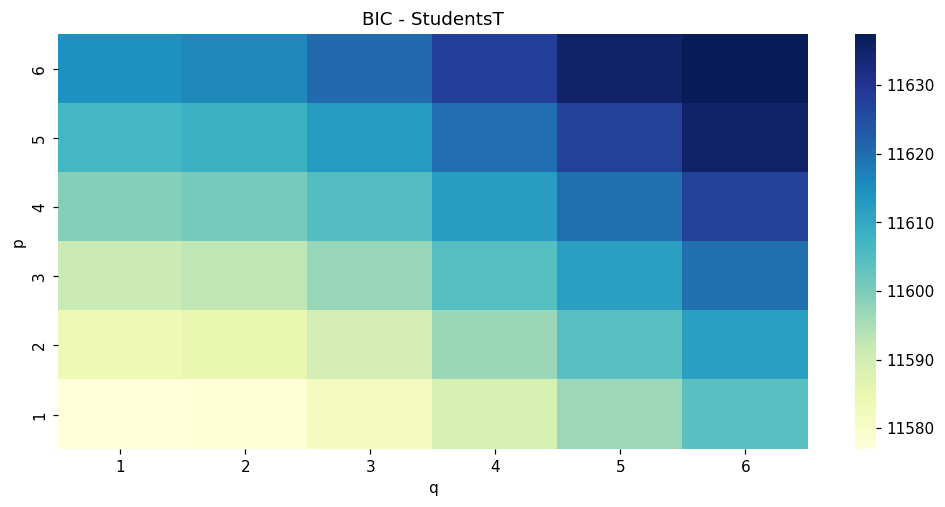

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


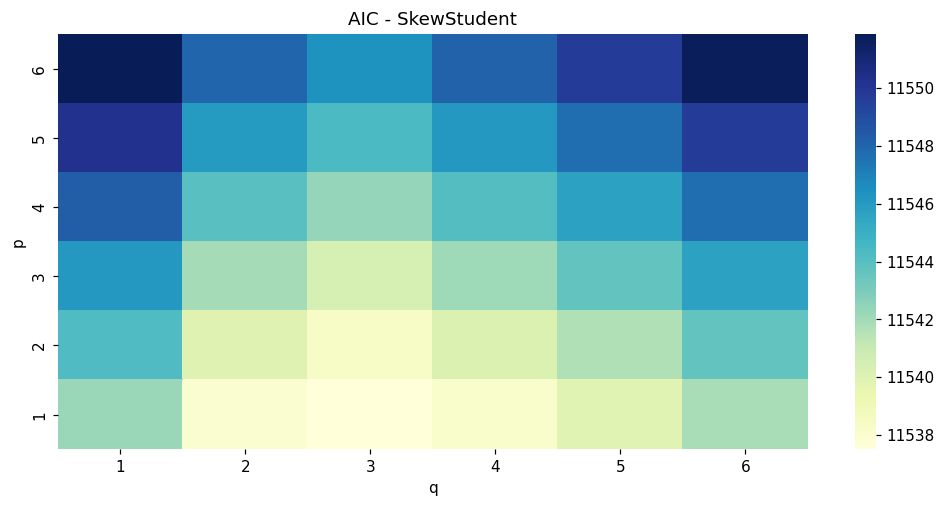

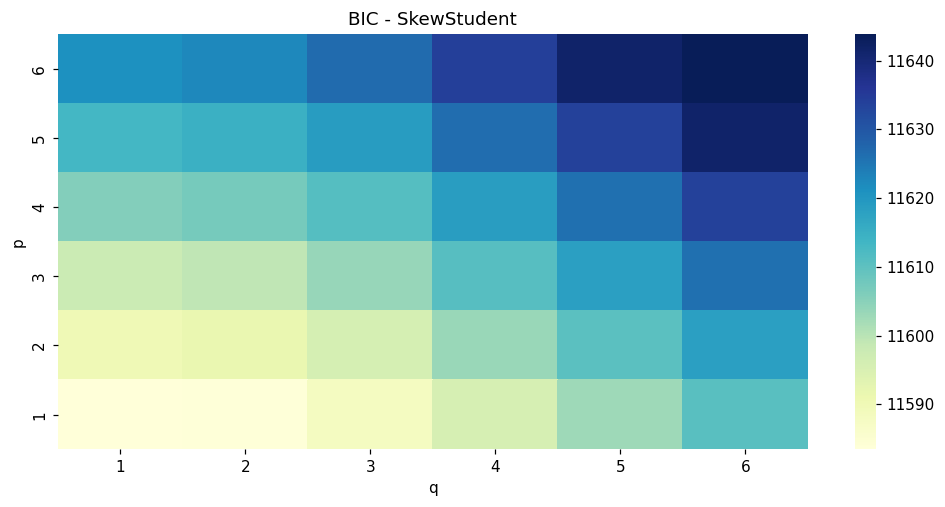



Normal distribution:  AIC choose [4, 2], BIC choose [4, 2]
Student distribution:  AIC choose [1, 3], BIC choose [1, 1]
Skew Student distribution:  AIC choose [1, 3], BIC choose [1, 1]


In [14]:
############################ G J R - G A R C H ######################################

#this function reutns aic and bic for a GJR-GARCH model
def info_gjr_garch(data, p,q, distribution):
    garch = arch.arch_model(data, p = p, o=1, q = q, dist = distribution)
    fit = garch.fit(update_freq=0, disp="off")
    return fit.aic, fit.bic

aic_norm, bic_norm = heat(train_set,"Normal", info_gjr_garch)
aic_stud, bic_stud = heat(train_set,"StudentsT", info_gjr_garch)
aic_skewt, bic_skewt = heat(train_set, "SkewStudent", info_gjr_garch)

print(f"\n\nNormal distribution:  AIC choose {aic_norm}, BIC choose {bic_norm}")
print(f"Student distribution:  AIC choose {aic_stud}, BIC choose {bic_stud}")
print(f"Skew Student distribution:  AIC choose {aic_skewt}, BIC choose {bic_skewt}")

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6120.16
Distribution:                  Normal   AIC:                           12258.3
Method:            Maximum Likelihood   BIC:                           12310.0
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:55:41   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0406  6.399e-02      0.634      0.526 [-8.48

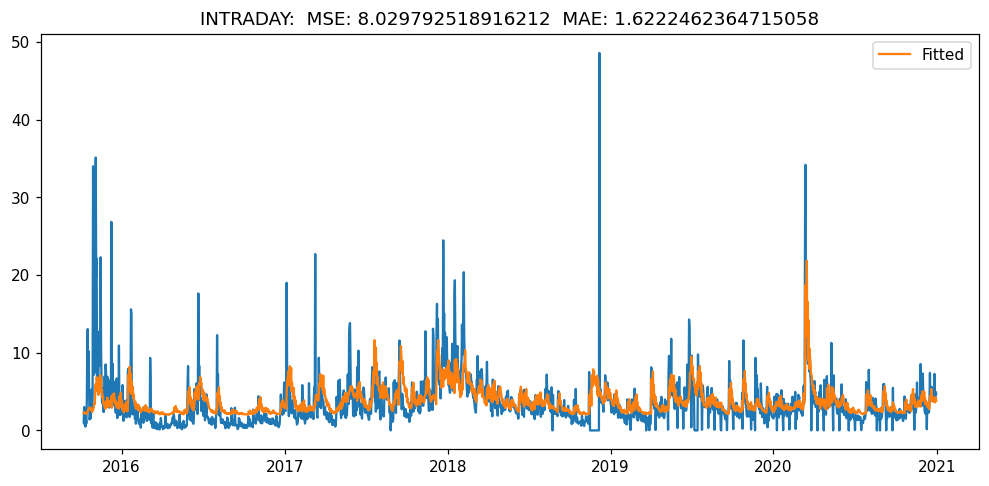

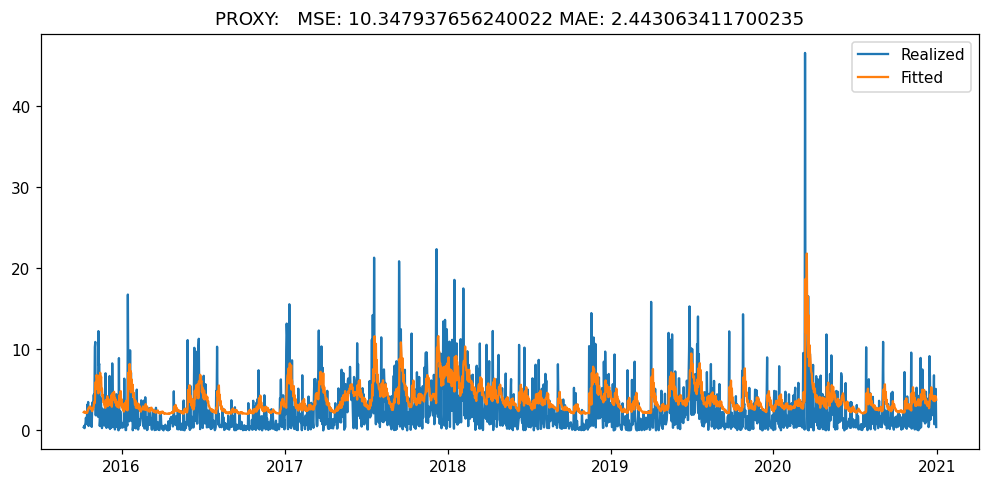

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6144.01
Distribution:                  Normal   AIC:                           12298.0
Method:            Maximum Likelihood   BIC:                           12326.7
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:55:42   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0431  5.767e-02      0.747      0.455 [-6.99

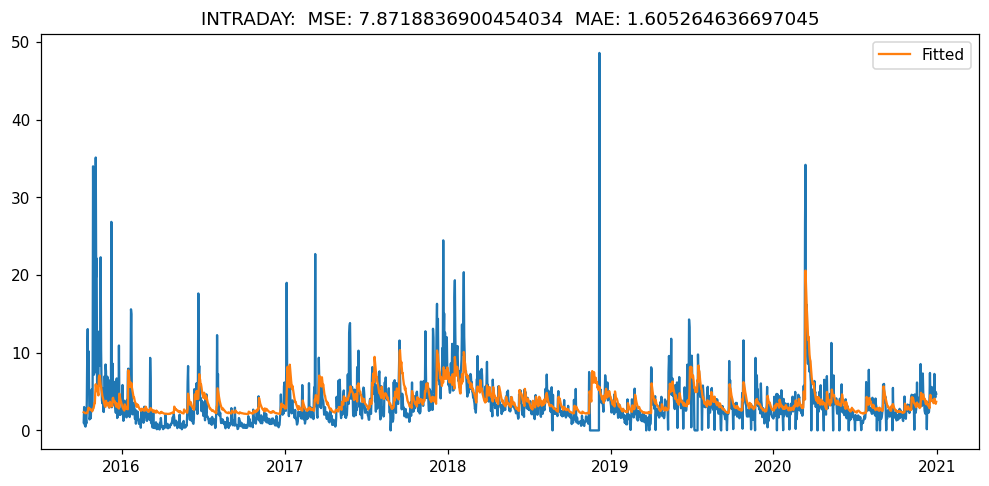

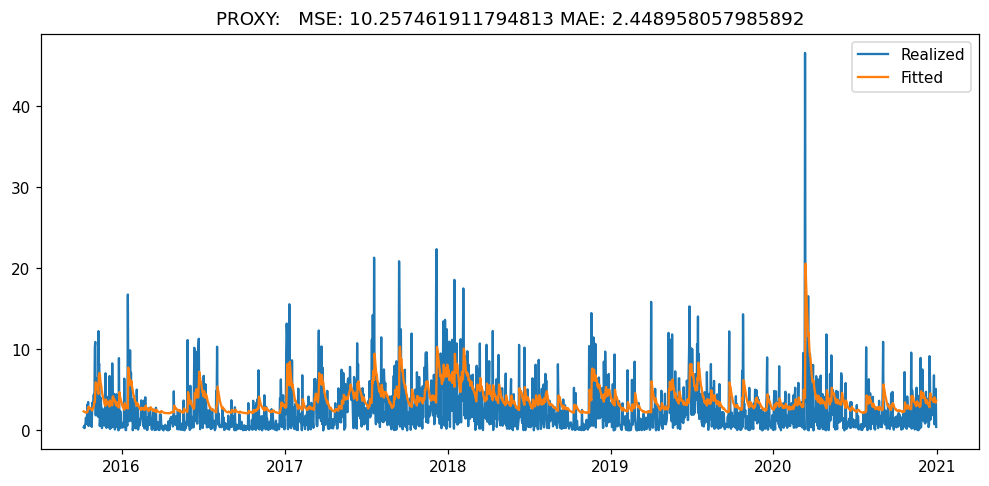

In [15]:
#confronting the models given by the normal 

#AIC and BIC chooses [4,2]
gjr_garch_42 = arch.arch_model(train_set, p = 4, o=1, q = 2 , dist = "Normal")
gjr_garch_42_fit = gjr_garch_42.fit(update_freq=0, disp="off")
print(gjr_garch_42_fit.summary())
visual(gjr_garch_42_fit)
observe_fitted_realized(gjr_garch_42_fit, train_set, True)
#note that a simple gjr 1,1 performs better 

#confronting with a [1,1] model
gjr_garch_11 = arch.arch_model(train_set, p = 1, o=1, q = 1 , dist = "Normal")
gjr_garch_11_fit = gjr_garch_11.fit(update_freq=0, disp="off")
print(gjr_garch_11_fit.summary())
visual(gjr_garch_11_fit)
observe_fitted_realized(gjr_garch_11_fit, train_set, True)


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5759.91
Distribution:      Standardized Student's t   AIC:                           11535.8
Method:                  Maximum Likelihood   BIC:                           11581.7
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:55:43   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

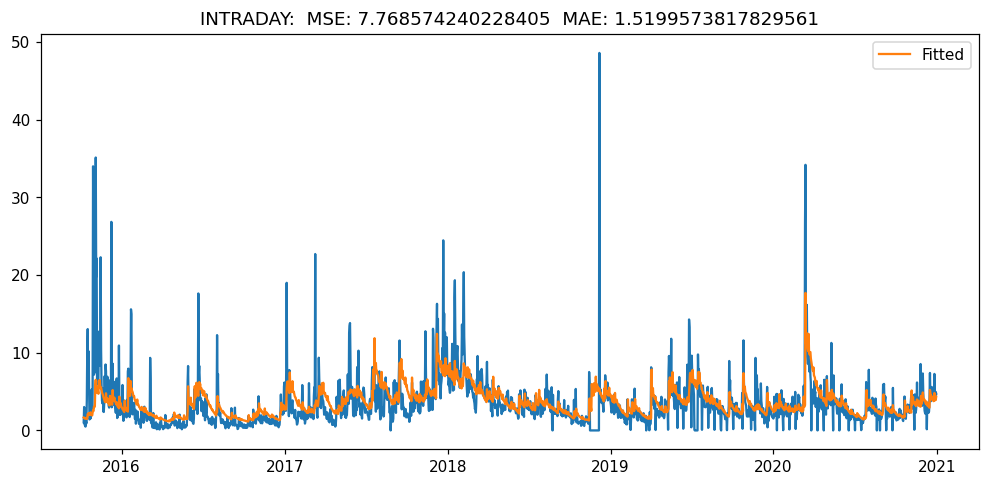

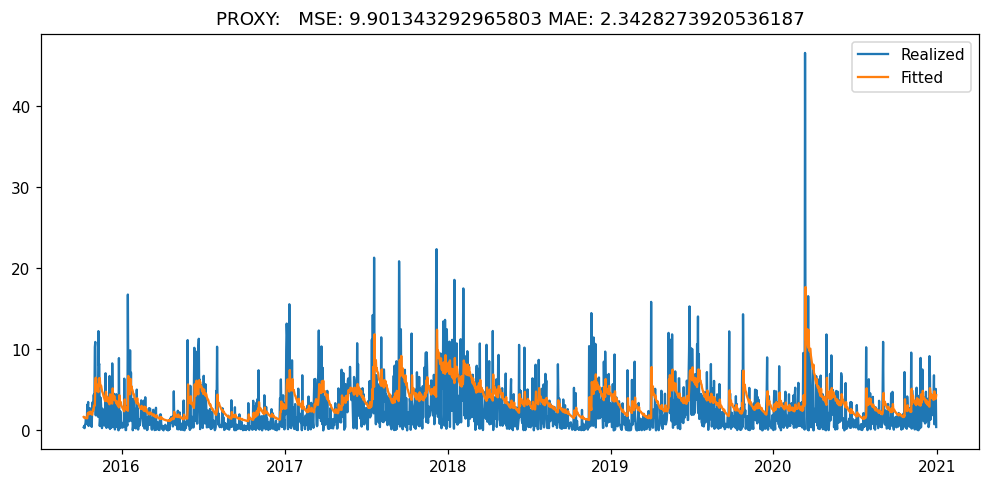





                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5764.70
Distribution:      Standardized Student's t   AIC:                           11541.4
Method:                  Maximum Likelihood   BIC:                           11575.8
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:55:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu 

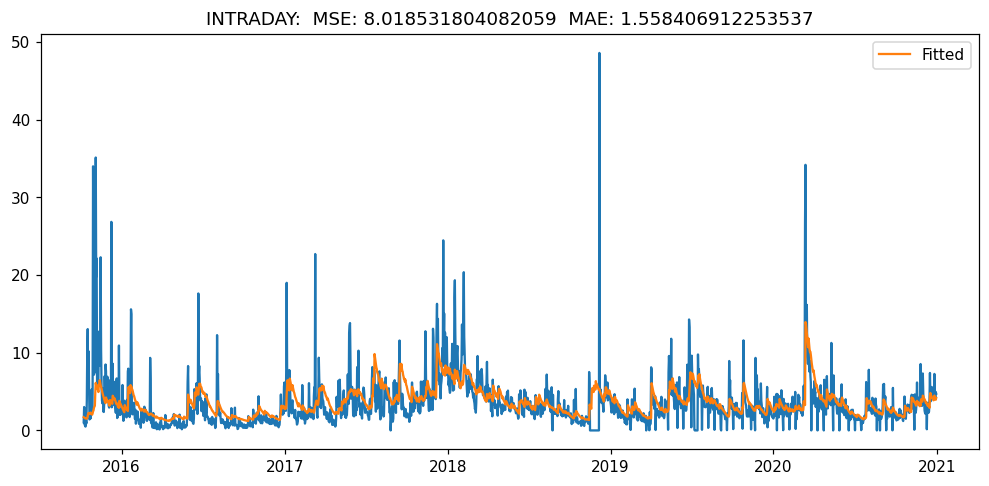

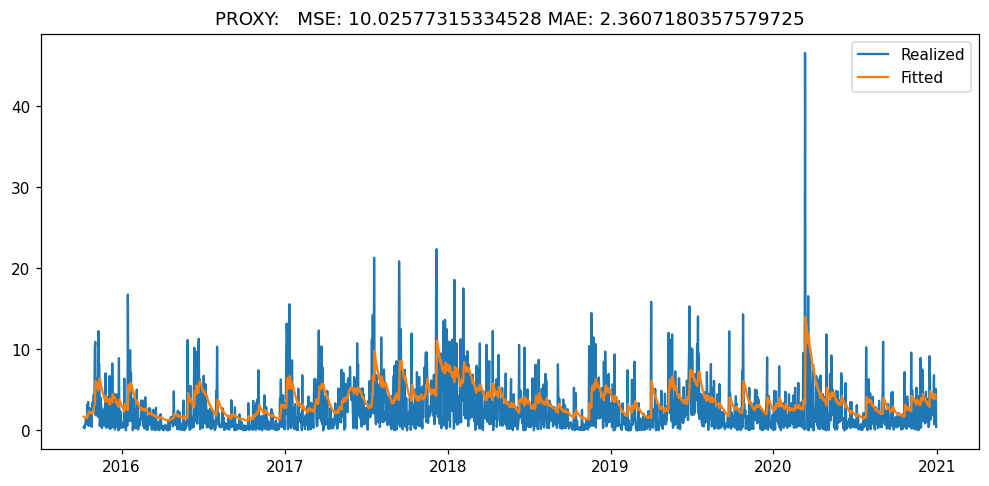

In [16]:
#confronting the models given by the Student 
#AIC chooses 
gjr_garch_13_t = arch.arch_model(train_set, p = 1, o=1, q = 3, dist = "StudentsT")
gjr_garch_13_t_fit = gjr_garch_13_t.fit(update_freq=0, disp="off")
print(gjr_garch_13_t_fit.summary())
visual(gjr_garch_13_t_fit)
observe_fitted_realized(gjr_garch_13_t_fit, train_set, True)

print("\n\n\n")



#BIC chooses 
gjr_garch_11_t = arch.arch_model(train_set, p = 1, o=1, q = 1, dist = "StudentsT")
gjr_garch_11_t_fit = gjr_garch_11_t.fit(update_freq=0, disp="off")
print(gjr_garch_11_t_fit.summary())
visual(gjr_garch_11_t_fit)
observe_fitted_realized(gjr_garch_11_t_fit, train_set, True)


                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5759.20
Distribution:      Standardized Skew Student's t   AIC:                           11536.4
Method:                       Maximum Likelihood   BIC:                           11588.0
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:55:44   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

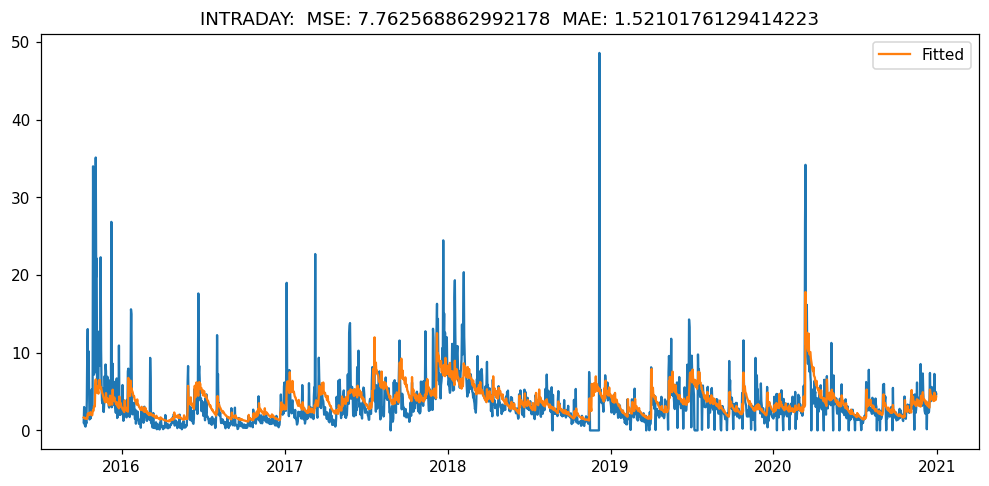

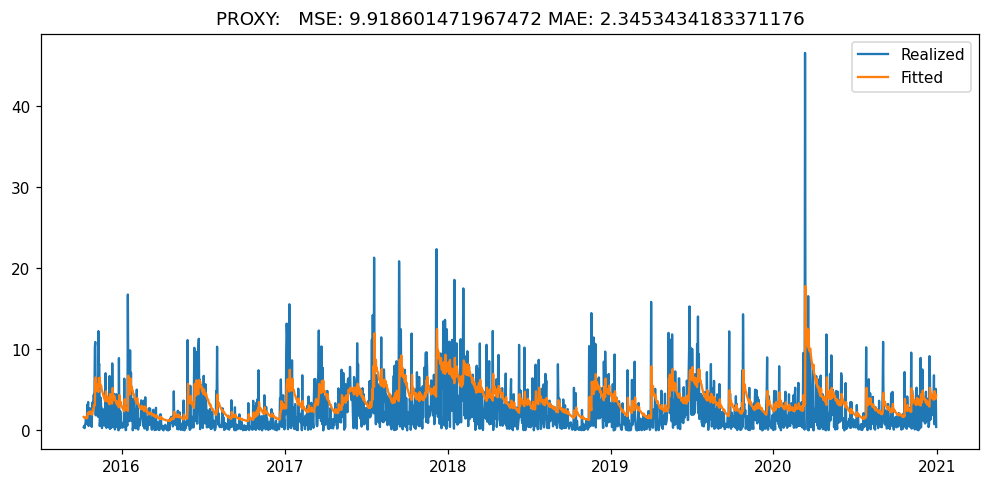





                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5764.13
Distribution:      Standardized Skew Student's t   AIC:                           11542.3
Method:                       Maximum Likelihood   BIC:                           11582.4
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:55:45   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
----------------------------------

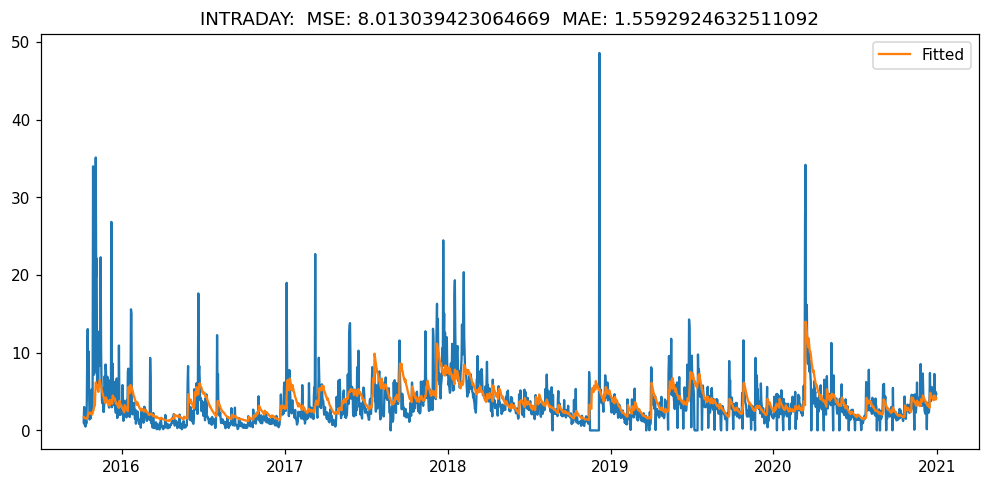

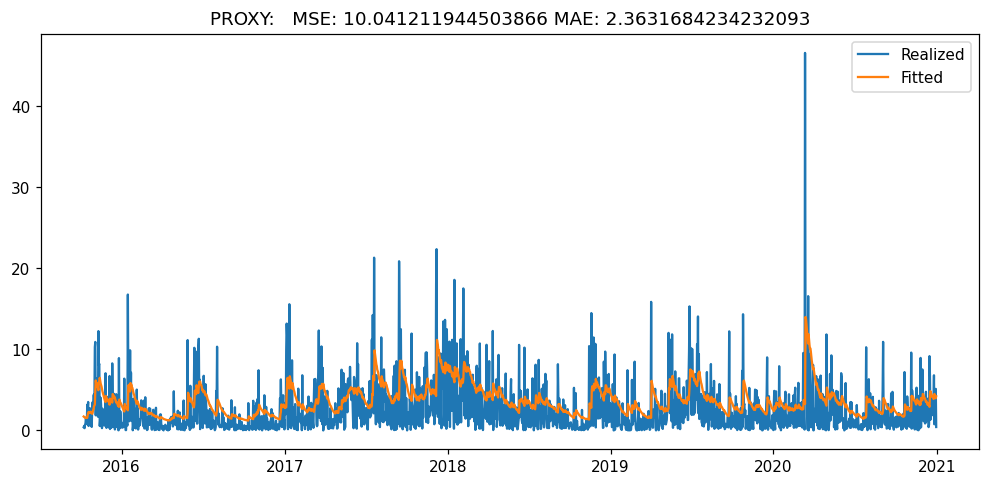

In [17]:
#confronting the models given by the skewStudent 
#AIC chooses 
gjr_garch_13_st = arch.arch_model(train_set, p = 1, o=1, q = 3, dist = "SkewStudent")
gjr_garch_13_st_fit = gjr_garch_13_st.fit(update_freq=0, disp="off")
print(gjr_garch_13_st_fit.summary())
visual(gjr_garch_13_st_fit)
observe_fitted_realized(gjr_garch_13_st_fit, train_set, True)

print("\n\n\n")

#BIC chooses 
gjr_garch_11_st = arch.arch_model(train_set, p = 1, o=1, q = 1, dist = "SkewStudent")
gjr_garch_11_st_fit = gjr_garch_11_st.fit(update_freq=0, disp="off")
print(gjr_garch_11_st_fit.summary())
visual(gjr_garch_11_st_fit)
observe_fitted_realized(gjr_garch_11_st_fit, train_set, True)


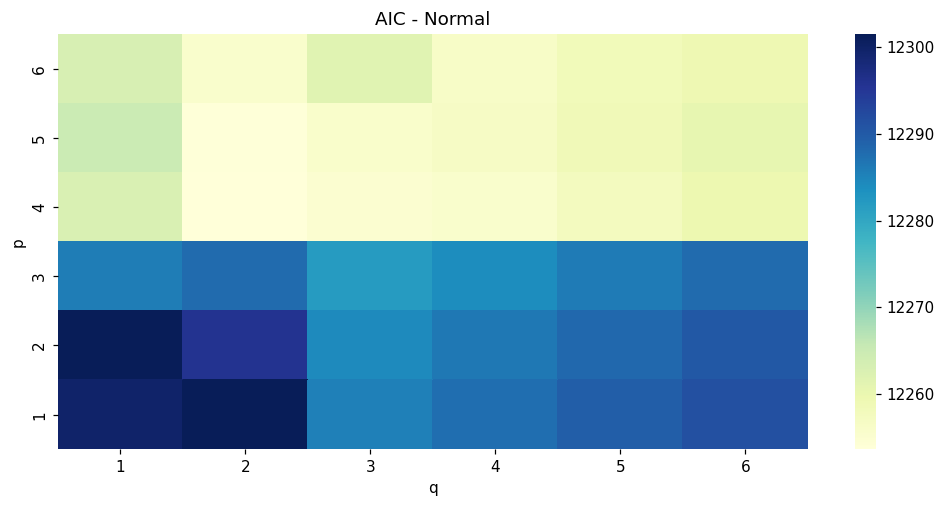

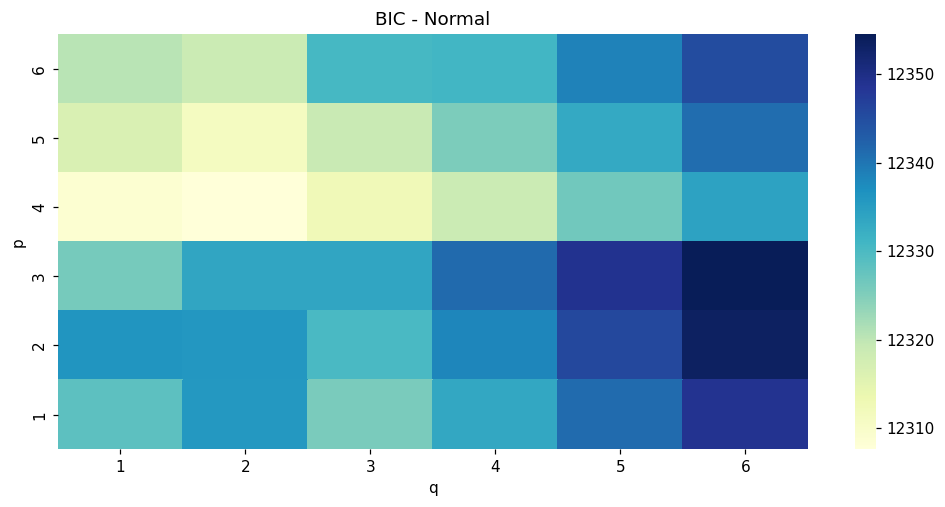

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


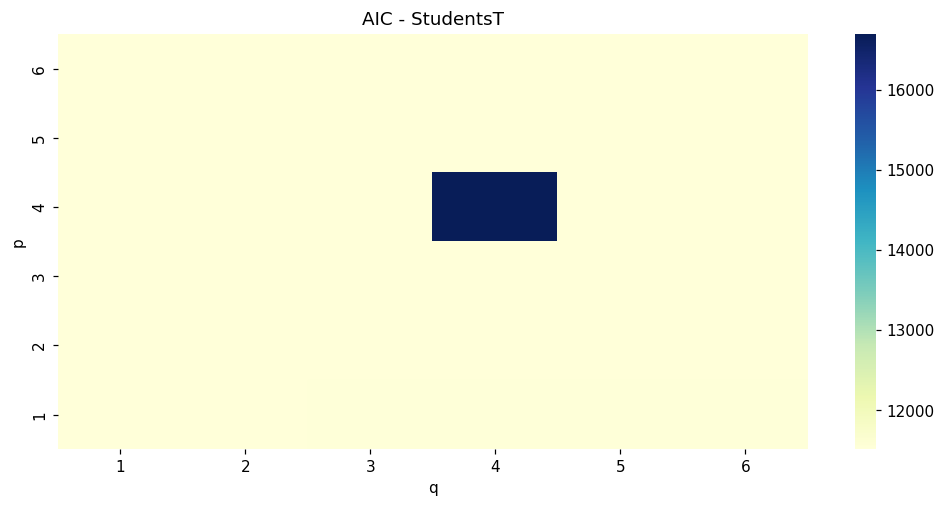

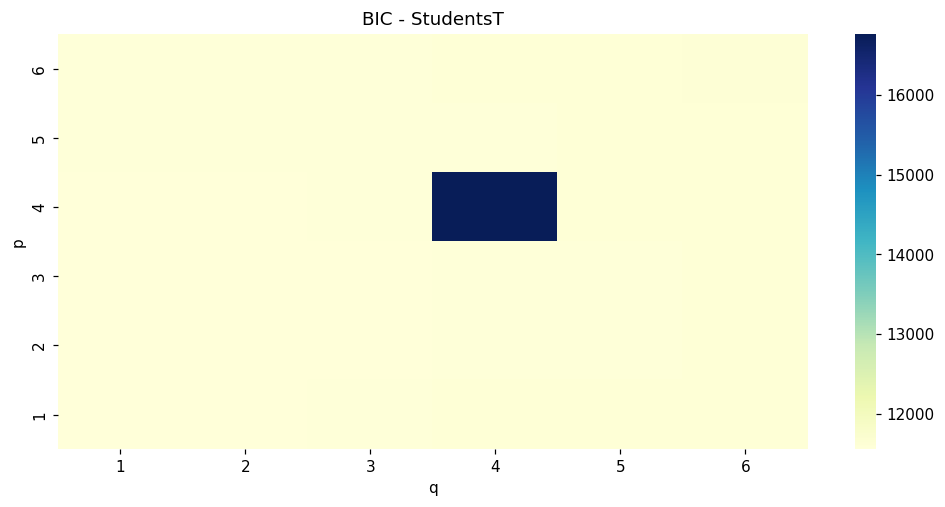

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: Converge

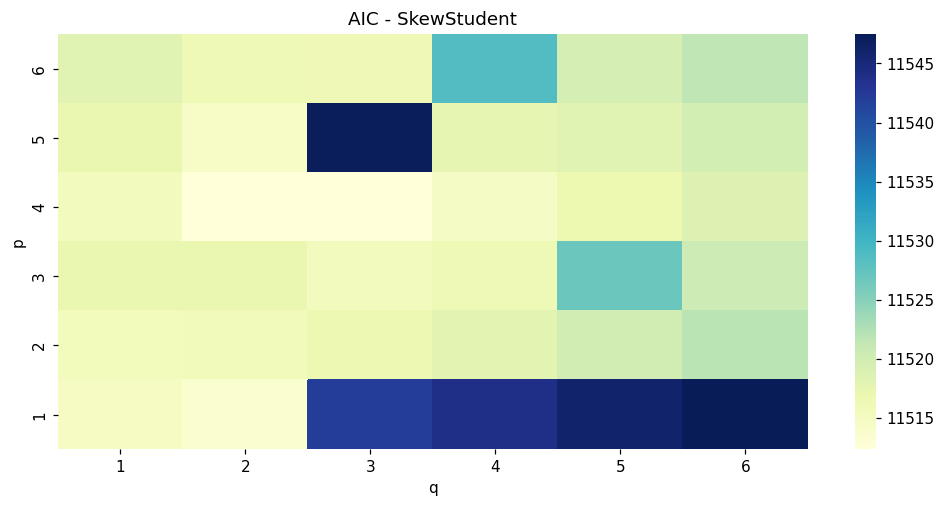

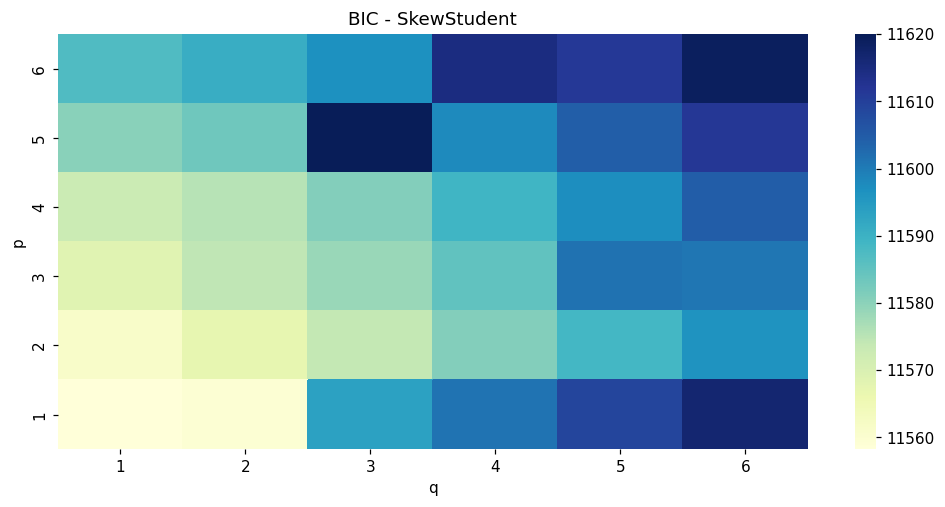



Normal distribution:  AIC choose [4, 2], BIC choose [4, 2]
Student distribution:  AIC choose [4, 2], BIC choose [1, 1]
Skew Student distribution:  AIC choose [4, 3], BIC choose [1, 1]


In [18]:
############################## APARCH MODEL ###########################################

#this function reutns aic and bic for a APARCH model
def info_aparch(data, p,q, distribution):
    garch = arch.arch_model(data, vol="APARCH", p=p, q=q, dist=distribution)
    fit = garch.fit(update_freq=0, disp="off")
    return fit.aic, fit.bic


aic_norm_a, bic_norm_a = heat(train_set,"Normal", info_aparch)
aic_stud_a, bic_stud_a = heat(train_set, "StudentsT", info_aparch)
aic_skt_a, bic_skt_a = heat(train_set,"SkewStudent", info_aparch)

print(f"\n\nNormal distribution:  AIC choose {aic_norm_a}, BIC choose {bic_norm_a}")
print(f"Student distribution:  AIC choose {aic_stud_a}, BIC choose {bic_stud_a}")
print(f"Skew Student distribution:  AIC choose {aic_skt_a}, BIC choose {bic_skt_a}")

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:               -6117.53
Distribution:                  Normal   AIC:                           12253.1
Method:            Maximum Likelihood   BIC:                           12304.7
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:57:47   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0315  7.558e-02      0.417      0.677 [ -0.117,  0.18

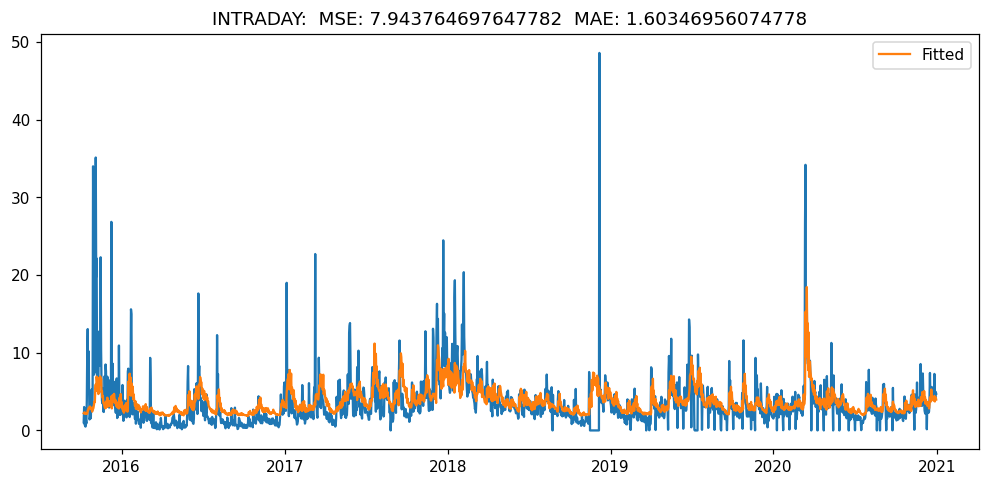

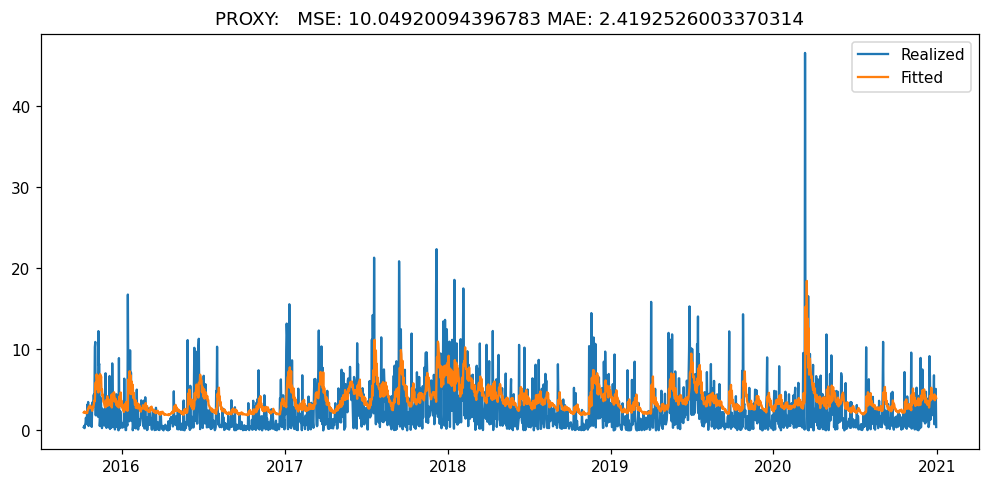

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:               -6144.90
Distribution:                  Normal   AIC:                           12299.8
Method:            Maximum Likelihood   BIC:                           12328.5
                                        No. Observations:                 2297
Date:                Sun, Jun 19 2022   Df Residuals:                     2296
Time:                        14:57:48   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0942  6.325e-02      1.490      0.136 [-2.97

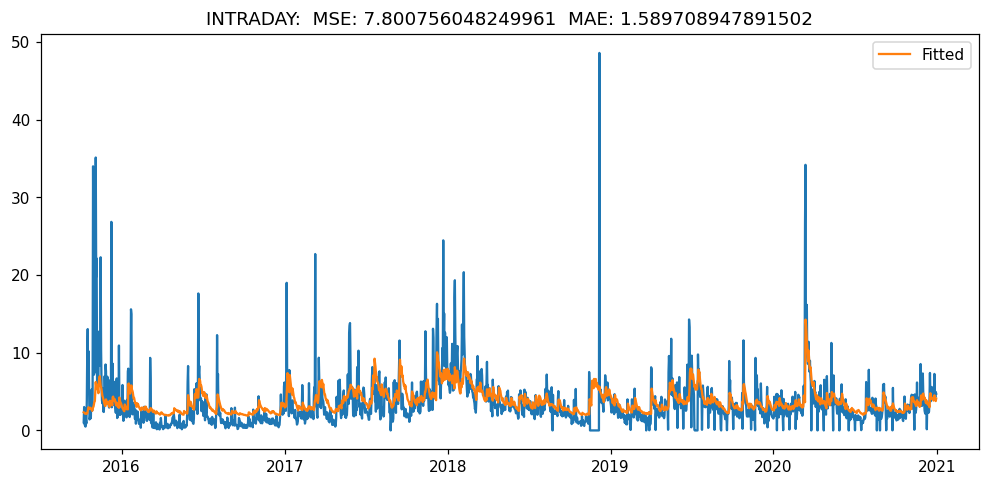

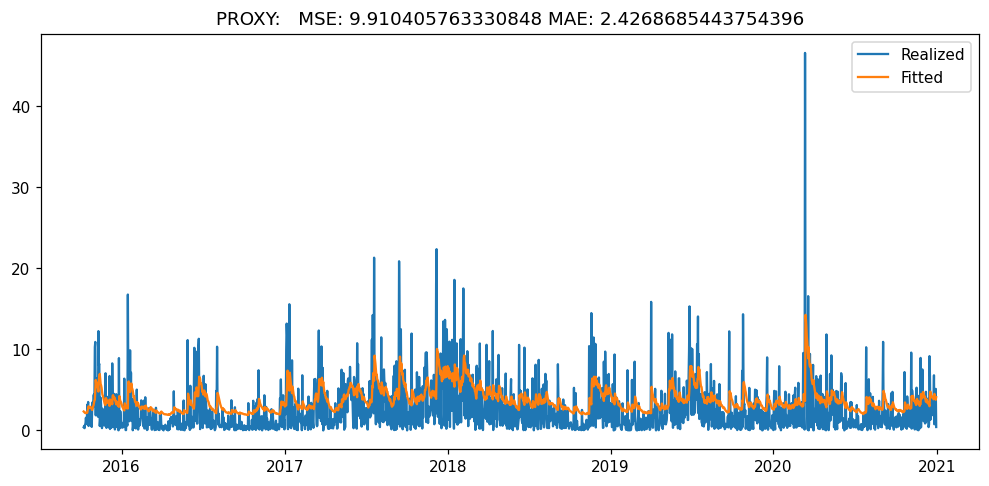

In [19]:
#confronting the models given by the normal 

#aic
aparch_garch_42 = arch.arch_model(train_set, vol="APARCH", p=4, q=2, dist="Normal")
aparch_garch_42_fit = aparch_garch_42.fit(update_freq=0, disp="off")
print(aparch_garch_42_fit.summary())
visual(aparch_garch_42_fit)
observe_fitted_realized(aparch_garch_42_fit, train_set, True)


#bic
aparch_garch_11 = arch.arch_model(train_set, vol="APARCH", p=1, q=1, dist="Normal")
aparch_garch_11_fit = aparch_garch_11.fit(update_freq=0, disp="off")
print(aparch_garch_11_fit.summary())
visual(aparch_garch_11_fit)
observe_fitted_realized(aparch_garch_11_fit, train_set, True)


                      Constant Mean - Power ARCH Model Results                      
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       Power ARCH   Log-Likelihood:               -5747.10
Distribution:      Standardized Student's t   AIC:                           11514.2
Method:                  Maximum Likelihood   BIC:                           11571.6
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:57:50   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

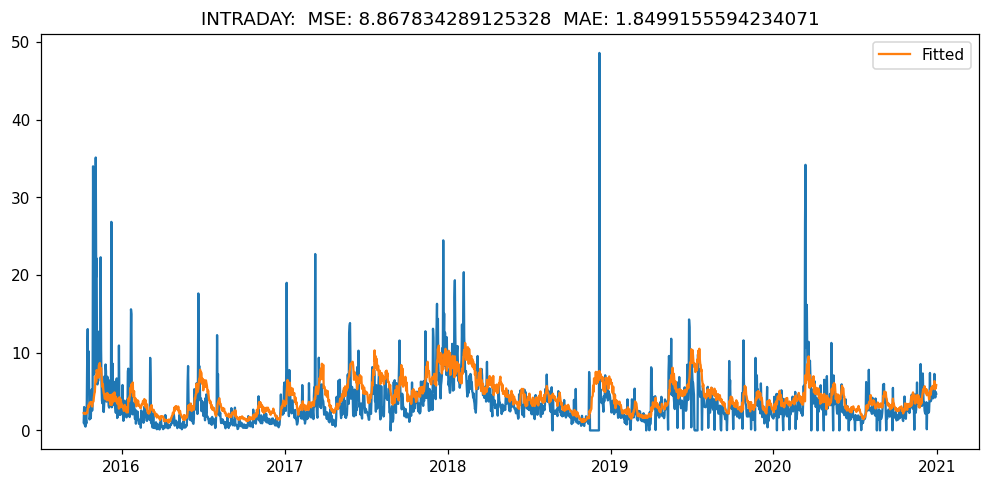

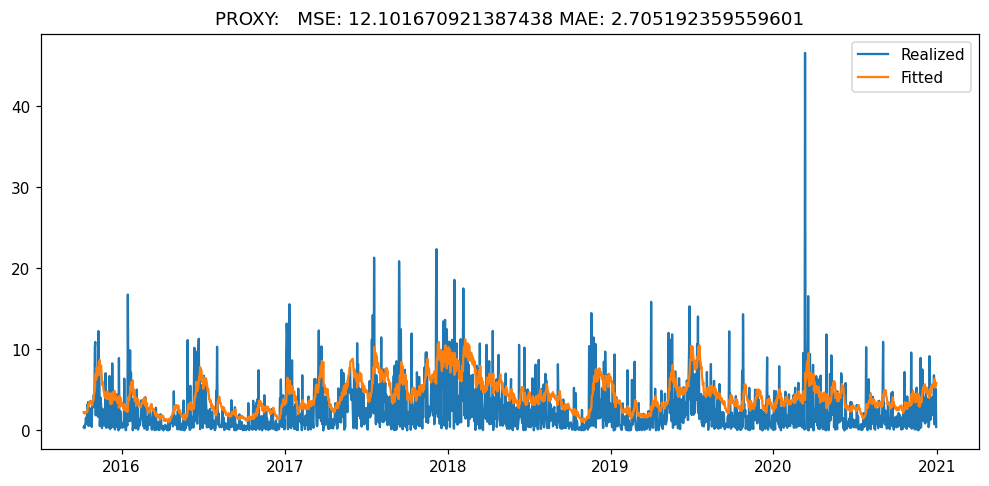

                      Constant Mean - Power ARCH Model Results                      
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       Power ARCH   Log-Likelihood:               -5751.29
Distribution:      Standardized Student's t   AIC:                           11514.6
Method:                  Maximum Likelihood   BIC:                           11549.0
                                              No. Observations:                 2297
Date:                      Sun, Jun 19 2022   Df Residuals:                     2296
Time:                              14:57:52   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

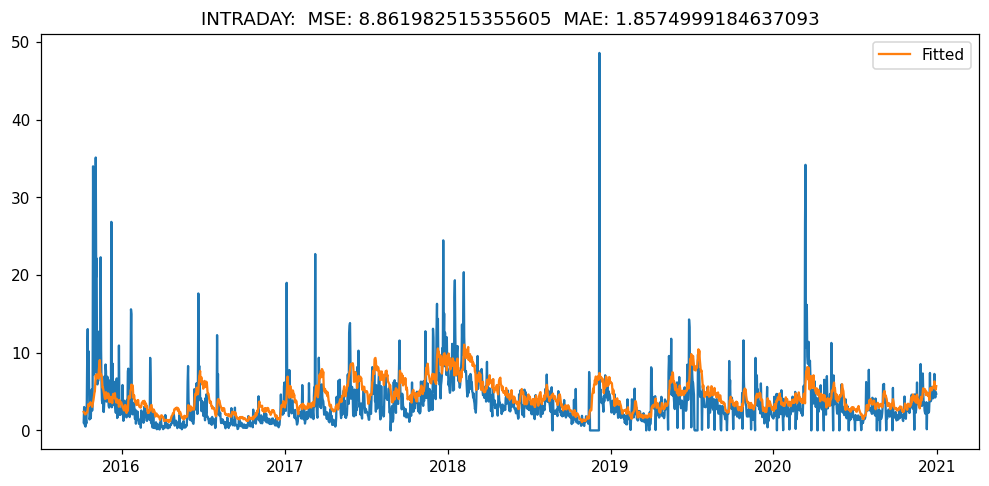

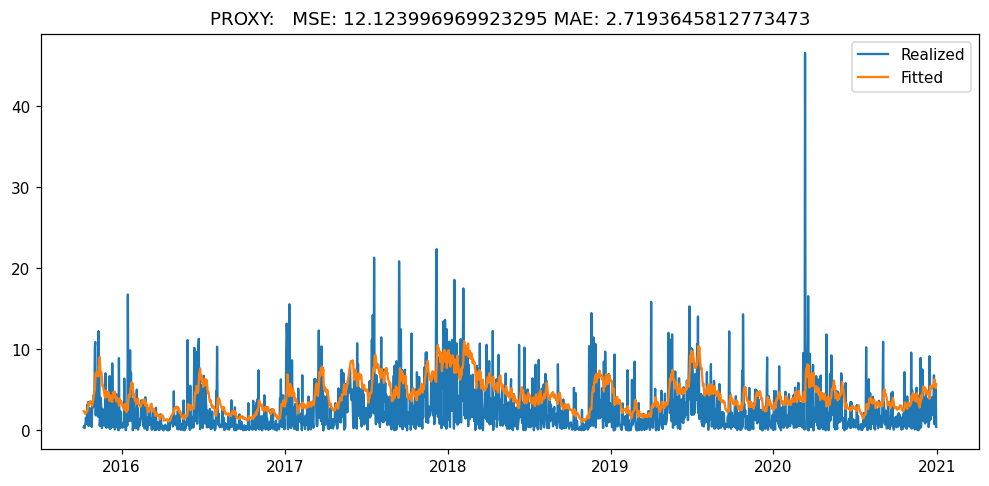

In [20]:
#confronting the models given by the standardized Student's T distribution
#aic
aparch_garch_42 = arch.arch_model(train_set, vol="APARCH", p=4, q=2, dist="Studentst")
aparch_garch_42_fit_t = aparch_garch_42.fit(update_freq=0, disp="off")
print(aparch_garch_42_fit_t.summary())
visual(aparch_garch_42_fit_t)
observe_fitted_realized(aparch_garch_42_fit_t, train_set, True)

#bic
aparch_garch_11 = arch.arch_model(train_set, vol="APARCH", p=1, q=1, dist="Studentst")
aparch_garch_11_fit_t = aparch_garch_11.fit(update_freq=0, disp="off")
print(aparch_garch_11_fit_t.summary())
visual(aparch_garch_11_fit_t)
observe_fitted_realized(aparch_garch_11_fit_t, train_set, True)

                         Constant Mean - Power ARCH Model Results                        
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            Power ARCH   Log-Likelihood:               -5744.07
Distribution:      Standardized Skew Student's t   AIC:                           11512.1
Method:                       Maximum Likelihood   BIC:                           11581.0
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:57:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------------------------

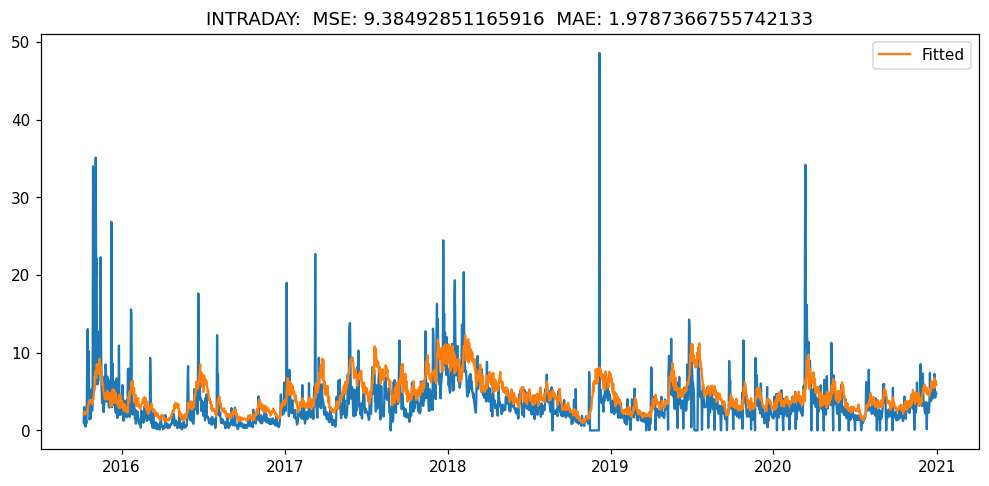

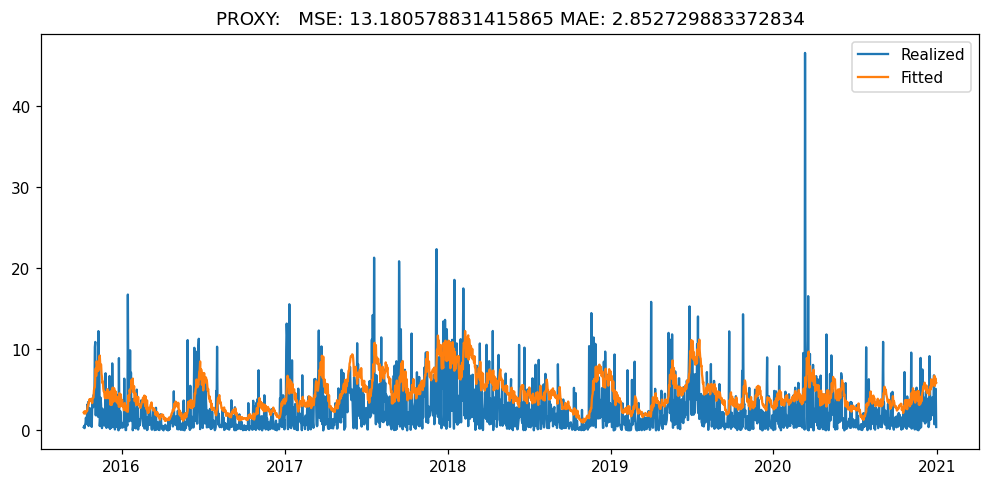

                         Constant Mean - Power ARCH Model Results                        
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            Power ARCH   Log-Likelihood:               -5750.44
Distribution:      Standardized Skew Student's t   AIC:                           11514.9
Method:                       Maximum Likelihood   BIC:                           11555.1
                                                   No. Observations:                 2297
Date:                           Sun, Jun 19 2022   Df Residuals:                     2296
Time:                                   14:57:55   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------

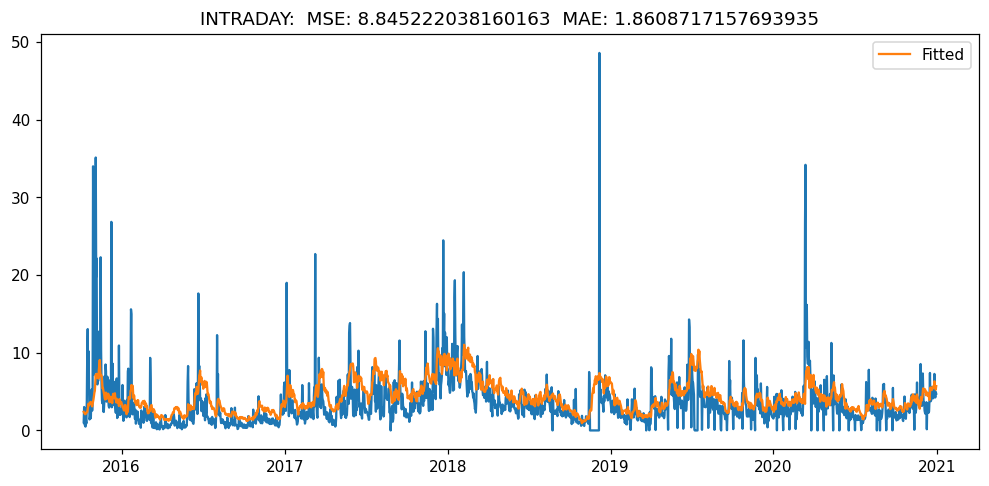

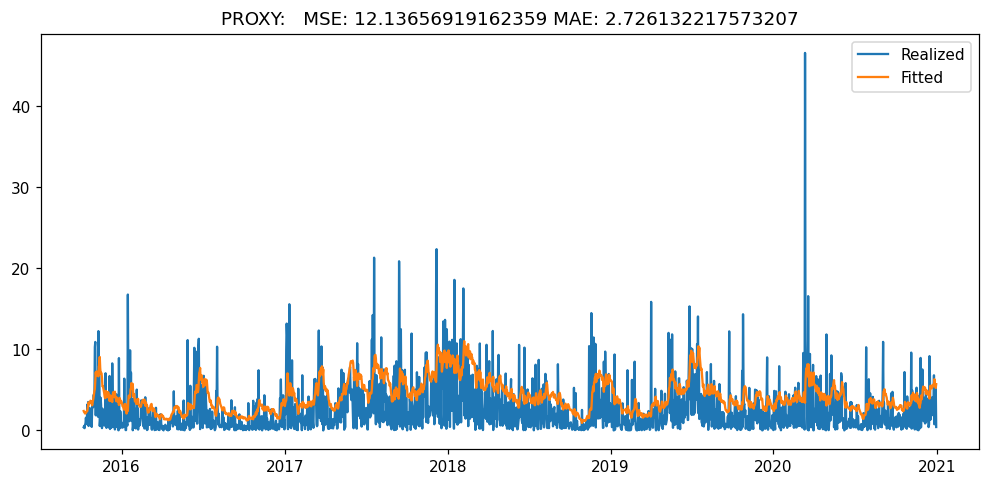

In [21]:
#confronting the models given by the skewed Student's T distribution

#aic
aparch_garch_43 = arch.arch_model(train_set, vol="APARCH", p=4, q=3, dist="SkewStudent")
aparch_garch_43_fit = aparch_garch_43.fit(update_freq=0, disp="off")
print(aparch_garch_43_fit.summary())
visual(aparch_garch_43_fit)
observe_fitted_realized(aparch_garch_43_fit, train_set, True)

#bic
aparch_garch_11 = arch.arch_model(train_set, vol="APARCH", p=1, q=1, dist="SkewStudent")
aparch_garch_11_fit_ss = aparch_garch_11.fit(update_freq=0, disp="off")
print(aparch_garch_11_fit_ss.summary())
visual(aparch_garch_11_fit_ss)
observe_fitted_realized(aparch_garch_11_fit_ss, train_set, True)


In [22]:


#compute the loss w.r.t. the 1m intraday proxy
def loss_intraday(fit, n_out = n_obs_to_avoid):
    gem_index = train_real.index            #implement to take data till last date     
    fitted_garch = fit.conditional_volatility.loc[(m_fit.conditional_volatility).notnull()]
    fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
    return [np.round(MSE(fitted_garch, remove_outliers(train_real,2)),2), np.round(MAE(fitted_garch, remove_outliers(train_real,2)),2)]


#compute the loss w.r.t. the 1h intraday proxy
def loss_intraday_1h(fit):
    gem_index = train_real.index            #implement to take data till last date     
    fitted_garch = fit.conditional_volatility.loc[(m_fit.conditional_volatility).notnull()]
    fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
    return [np.round(MSE(fitted_garch, train_real_1h),2), np.round(MAE(fitted_garch, train_real_1h),2)]

#compute the loss w.r.t. the naive proxy
def loss_proxy(fit_model, perc_r = perc_r,vol = True):   #vol is volatility 
    if not vol:  #variance
        gem_index = train_real.index            #implement to take data till last date     
        fitted_garch = fit_model.conditional_volatility.loc[(fit_model.conditional_volatility).notnull()]
        fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
        real = (train_set.loc[(train_set.index.isin(gem_index))])**2   
        return [np.round(MSE(real, fitted_garch**2),2), np.round(MAE(real, fitted_garch**2),2)]

    else:
      #volatility
        gem_index = train_real.index            #implement to take data till last date     
        fitted_garch = fit_model.conditional_volatility.loc[(fit_model.conditional_volatility).notnull()]
        fitted_garch = fitted_garch.loc[fitted_garch.index.isin(gem_index.to_list())]
        real = train_set.loc[(train_set.index.isin(gem_index))].abs()
        return [np.round(MSE(real, fitted_garch),2), np.round(MAE(real, fitted_garch),2)]

                                                                 

#create table of the best 23 models
best_models = [["GARCH", "4/2", "Normal", np.round(garch_42_fit.aic, 1), np.round(garch_42_fit.bic,1), loss_intraday(garch_42_fit)[0], loss_intraday(garch_42_fit)[1], loss_intraday_1h(garch_42_fit)[0], loss_intraday_1h(garch_42_fit)[1], loss_proxy(garch_42_fit)[0], loss_proxy(garch_42_fit)[1]],
               ["GARCH", "1/3", "StudentsT", np.round(garch_13_fit.aic, 1), np.round(garch_13_fit.bic, 1), loss_intraday(garch_13_fit)[0], loss_intraday(garch_13_fit)[1], loss_intraday_1h(garch_13_fit)[0], loss_intraday_1h(garch_13_fit)[1], loss_proxy(garch_13_fit)[0], loss_proxy(garch_13_fit)[1]],
               ["GARCH", "1/1", "StudentsT", np.round(garch_11_fit.aic, 1), np.round(garch_11_fit.bic, 1), loss_intraday(garch_11_fit)[0], loss_intraday(garch_11_fit)[1], loss_intraday_1h(garch_11_fit)[0], loss_intraday_1h(garch_11_fit)[1], loss_proxy(garch_11_fit)[0], loss_proxy(garch_11_fit)[1]],
               ["GARCH", "1/3", "SkewStudent", np.round(garch_13_fit_ss.aic, 1), np.round(garch_13_fit_ss.bic, 1), loss_intraday(garch_13_fit_ss)[0], loss_intraday(garch_13_fit_ss)[1], loss_intraday_1h(garch_13_fit_ss)[0], loss_intraday_1h(garch_13_fit_ss)[1], loss_proxy(garch_13_fit_ss)[0], loss_proxy(garch_13_fit_ss)[1]],
               ["GARCH", "1/1", "SkewStudent", np.round(garch_11_fit_ss.aic, 1), np.round(garch_11_fit_ss.bic, 1), loss_intraday(garch_11_fit_ss)[0], loss_intraday(garch_11_fit_ss)[1], loss_intraday_1h(garch_11_fit_ss)[0], loss_intraday_1h(garch_11_fit_ss)[1], loss_proxy(garch_11_fit_ss)[0], loss_proxy(garch_11_fit_ss)[1]],
               ["EGARCH","5/1", "Normal", np.round(e_garch_51_fit.aic, 1), np.round(e_garch_51_fit.bic, 1), loss_intraday(e_garch_51_fit)[0], loss_intraday(e_garch_51_fit)[1], loss_intraday_1h(e_garch_51_fit)[0], loss_intraday_1h(e_garch_51_fit)[1], loss_proxy(e_garch_51_fit)[0], loss_proxy(e_garch_51_fit)[1]],
               ["EGARCH","4/1", "Normal", np.round(e_garch_41_fit.aic, 1), np.round(e_garch_41_fit.bic, 1), loss_intraday(e_garch_41_fit)[0], loss_intraday(e_garch_41_fit)[1], loss_intraday_1h(e_garch_41_fit)[0], loss_intraday_1h(e_garch_41_fit)[1], loss_proxy(e_garch_41_fit)[0], loss_proxy(e_garch_41_fit)[1]],
               ["EGARCH","2/1", "StudentsT", np.round(e_garch_21_fit.aic, 1), np.round(e_garch_21_fit.bic, 1), loss_intraday(e_garch_21_fit)[0], loss_intraday(e_garch_21_fit)[1], loss_intraday_1h(e_garch_21_fit)[0], loss_intraday_1h(e_garch_21_fit)[1], loss_proxy(e_garch_21_fit)[0], loss_proxy(e_garch_21_fit)[1]],
               ["EGARCH","1/1", "StudentsT", np.round(e_garch_11_fit.aic, 1), np.round(e_garch_11_fit.bic, 1), loss_intraday(e_garch_11_fit)[0], loss_intraday(e_garch_11_fit)[1], loss_intraday_1h(e_garch_11_fit)[0], loss_intraday_1h(e_garch_11_fit)[1], loss_proxy(e_garch_11_fit)[0], loss_proxy(e_garch_11_fit)[1]],
               ["EGARCH","2/1", "SkewStudent", np.round(e_garch_21_fit_ss.aic, 1), np.round(e_garch_21_fit_ss.bic, 1), loss_intraday(e_garch_21_fit_ss)[0], loss_intraday(e_garch_21_fit_ss)[1], loss_intraday_1h(e_garch_21_fit_ss)[0], loss_intraday_1h(e_garch_21_fit_ss)[1], loss_proxy(e_garch_21_fit_ss)[0], loss_proxy(e_garch_21_fit_ss)[1]],
               ["EGARCH","1/1", "SkewStudent", np.round(e_garch_11_fit_ss.aic, 1), np.round(e_garch_11_fit_ss.bic, 1), loss_intraday(e_garch_11_fit_ss)[0], loss_intraday(e_garch_11_fit_ss)[1], loss_intraday_1h(e_garch_11_fit_ss)[0], loss_intraday_1h(e_garch_11_fit_ss)[1], loss_proxy(e_garch_11_fit_ss)[0], loss_proxy(e_garch_11_fit_ss)[1]],
               ["GJR GARCH","4/2", "Normal", np.round(gjr_garch_42_fit.aic, 1), np.round(gjr_garch_42_fit.bic, 1), loss_intraday(gjr_garch_42_fit)[0], loss_intraday(gjr_garch_42_fit)[1], loss_intraday_1h(gjr_garch_42_fit)[0], loss_intraday_1h(gjr_garch_42_fit)[1], loss_proxy(gjr_garch_42_fit)[0], loss_proxy(gjr_garch_42_fit)[1]],
               ["GJR GARCH","1/1", "Normal", np.round(gjr_garch_11_fit.aic, 1), np.round(gjr_garch_11_fit.bic, 1), loss_intraday(gjr_garch_11_fit)[0], loss_intraday(gjr_garch_11_fit)[1], loss_intraday_1h(gjr_garch_11_fit)[0], loss_intraday_1h(gjr_garch_11_fit)[1], loss_proxy(gjr_garch_11_fit)[0], loss_proxy(gjr_garch_11_fit)[1]],
               ["GJR GARCH","1/3", "StudentsT", np.round(gjr_garch_13_t_fit.aic, 1), np.round(gjr_garch_13_t_fit.bic, 1), loss_intraday(gjr_garch_13_t_fit)[0], loss_intraday(gjr_garch_13_t_fit)[1], loss_intraday_1h(gjr_garch_13_t_fit)[0], loss_intraday_1h(gjr_garch_13_t_fit)[1], loss_proxy(gjr_garch_13_t_fit)[0], loss_proxy(gjr_garch_13_t_fit)[1]],
               ["GJR GARCH","1/1", "StudentsT", np.round(gjr_garch_11_t_fit.aic, 1), np.round(gjr_garch_11_t_fit.bic, 1), loss_intraday(gjr_garch_11_t_fit)[0], loss_intraday(gjr_garch_11_t_fit)[1], loss_intraday_1h(gjr_garch_11_t_fit)[0], loss_intraday_1h(gjr_garch_11_t_fit)[1], loss_proxy(gjr_garch_11_t_fit)[0], loss_proxy(gjr_garch_11_t_fit)[1]],
               ["GJR GARCH","1/3", "SkewStudent", np.round(gjr_garch_13_st_fit.aic, 1), np.round(gjr_garch_13_st_fit.bic, 1), loss_intraday(gjr_garch_13_st_fit)[0], loss_intraday(gjr_garch_13_st_fit)[1], loss_intraday_1h(gjr_garch_13_st_fit)[0], loss_intraday_1h(gjr_garch_13_st_fit)[1], loss_proxy(gjr_garch_13_st_fit)[0], loss_proxy(gjr_garch_13_st_fit)[1]],
               ["GJR GARCH","1/1", "SkewStudent", np.round(gjr_garch_11_st_fit.aic, 1), np.round(gjr_garch_11_st_fit.bic, 1), loss_intraday(gjr_garch_11_st_fit)[0], loss_intraday(gjr_garch_11_st_fit)[1], loss_intraday_1h(gjr_garch_11_st_fit)[0], loss_intraday_1h(gjr_garch_11_st_fit)[1], loss_proxy(gjr_garch_11_st_fit)[0], loss_proxy(gjr_garch_11_st_fit)[1]],
               ["APARCH","4/2", "Normal", np.round(aparch_garch_42_fit.aic, 1), np.round(aparch_garch_42_fit.bic, 1), loss_intraday(aparch_garch_42_fit)[0], loss_intraday(aparch_garch_42_fit)[1], loss_intraday_1h(aparch_garch_42_fit)[0], loss_intraday_1h(aparch_garch_42_fit)[1], loss_proxy(aparch_garch_42_fit)[0], loss_proxy(aparch_garch_42_fit)[1]],
               ["APARCH","1/1", "Normal", np.round(aparch_garch_11_fit.aic, 1), np.round(aparch_garch_11_fit.bic, 1), loss_intraday(aparch_garch_11_fit)[0], loss_intraday(aparch_garch_11_fit)[1], loss_intraday_1h(aparch_garch_11_fit)[0], loss_intraday_1h(aparch_garch_11_fit)[1], loss_proxy(aparch_garch_11_fit)[0], loss_proxy(aparch_garch_11_fit)[1]],
               ["APARCH","4/2", "StudentsT", np.round(aparch_garch_42_fit_t.aic, 1), np.round(aparch_garch_42_fit_t.bic, 1), loss_intraday(aparch_garch_42_fit_t)[0], loss_intraday(aparch_garch_42_fit_t)[1], loss_intraday_1h(aparch_garch_42_fit_t)[0], loss_intraday_1h(aparch_garch_42_fit_t)[1], loss_proxy(aparch_garch_42_fit_t)[0], loss_proxy(aparch_garch_42_fit_t)[1]],
               ["APARCH","1/1", "StudentsT", np.round(aparch_garch_11_fit_t.aic, 1), np.round(aparch_garch_11_fit_t.bic, 1), loss_intraday(aparch_garch_11_fit_t)[0], loss_intraday(aparch_garch_11_fit_t)[1], loss_intraday_1h(aparch_garch_11_fit_t)[0], loss_intraday_1h(aparch_garch_11_fit_t)[1], loss_proxy(aparch_garch_11_fit_t)[0], loss_proxy(aparch_garch_11_fit_t)[1]],
               ["APARCH","4/3", "SkewStudent", np.round(aparch_garch_43_fit.aic, 1), np.round(aparch_garch_43_fit.bic, 1), loss_intraday(aparch_garch_43_fit)[0], loss_intraday(aparch_garch_43_fit)[1], loss_intraday_1h(aparch_garch_43_fit)[0], loss_intraday_1h(aparch_garch_43_fit)[1], loss_proxy(aparch_garch_43_fit)[0], loss_proxy(aparch_garch_43_fit)[1]],
               ["APARCH","1/1", "SkewStudent", np.round(aparch_garch_11_fit_ss.aic, 1), np.round(aparch_garch_11_fit_ss.bic, 1), loss_intraday(aparch_garch_11_fit_ss)[0], loss_intraday(aparch_garch_11_fit_ss)[1], loss_intraday_1h(aparch_garch_11_fit_ss)[0], loss_intraday_1h(aparch_garch_11_fit_ss)[1], loss_proxy(aparch_garch_11_fit_ss)[0], loss_proxy(aparch_garch_11_fit_ss)[1]]]
df = pd.DataFrame(best_models, columns = ["Model", "p/q", "Distr.", "AIC", "BIC", "intra_MSE_1m", "intra_MAE_1m", "intra_MSE_1h", "intra_MAE_1h", "MSE", "MAE"])
df

Model  p/q       Distr.      AIC      BIC  intra_MSE_1m  intra_MAE_1m  \
0       GARCH  4/2       Normal  12256.3  12302.2          8.03          1.62   
1       GARCH  1/3    StudentsT  11541.2  11581.4          7.73          1.53   
2       GARCH  1/1    StudentsT  11545.8  11574.5          8.00          1.56   
3       GARCH  1/3  SkewStudent  11542.0  11587.9          7.73          1.52   
4       GARCH  1/1  SkewStudent  11546.7  11581.2          7.99          1.56   
5      EGARCH  5/1       Normal  12248.6  12300.3          7.87          1.60   
6      EGARCH  4/1       Normal  12249.0  12295.0          7.82          1.60   
7      EGARCH  2/1    StudentsT  11494.3  11534.5          9.16          2.01   
8      EGARCH  1/1    StudentsT  11500.0  11534.4          9.56          2.06   
9      EGARCH  2/1  SkewStudent  11494.6  11540.5          9.25          2.03   
10     EGARCH  1/1  SkewStudent  11500.1  11540.3          9.66          2.08   
11  GJR GARCH  4/2       Normal  12258.3  12310.0          8.03          1.62   
12  GJR GARCH  1/1       Normal  12298.0  12326.7          7.87          1.61   
13  GJR GARCH  1/3    StudentsT  11535.8  11581.7          7.77          1.52   
14  GJR GARCH  1/1    StudentsT  11541.4  11575.8          8.02          1.56   
15  GJR GARCH  1/3  SkewStudent  11536.4  11588.0          7.76          1.52   
16  GJR GARCH  1/1  SkewStudent  11542.3  11582.4          8.01          1.56   
17     APARCH  4/2       Normal  12253.1  12304.7          7.94          1.60   
18     APARCH  1/1       Normal  12299.8  12328.5          7.80          1.59   
19     APARCH  4/2    StudentsT  11514.2  11571.6          8.87          1.85   
20     APARCH  1/1    StudentsT  11514.6  11549.0          8.86          1.86   
21     APARCH  4/3  SkewStudent  11512.1  11581.0          9.38          1.98   
22     APARCH  1/1  SkewStudent  11514.9  11555.1          8.85          1.86   

    intra_MSE_1h  intra_MAE_1h    MSE   MAE  
0           4.93          1.59  10.35  2.44  
1           4.59          1.48  10.06  2.36  
2           4.82          1.52  10.19  2.38  
3           4.59          1.48  10.06  2.36  
4           4.81          1.52  10.20  2.38  
5           4.85          1.56   9.89  2.41  
6           4.82          1.56   9.93  2.41  
7           6.63          2.02  14.24  2.96  
8           6.90          2.06  14.09  2.97  
9           6.74          2.05  14.44  2.98  
10          7.02          2.09  14.31  2.99  
11          4.93          1.59  10.35  2.44  
12          4.72          1.57  10.26  2.45  
13          4.67          1.48   9.90  2.34  
14          4.88          1.52  10.03  2.36  
15          4.67          1.48   9.92  2.35  
16          4.88          1.52  10.04  2.36  
17          4.83          1.57  10.05  2.42  
18          4.67          1.56   9.91  2.43  
19          6.03          1.84  12.10  2.71  
20          6.02          1.85  12.12  2.72  
21          6.68          1.97  13.18  2.85  
22          6.02          1.85  12.14  2.73

In [23]:
#create the table with the best models for each columns
from google.colab import files
def bestmodels(tab):
    ind = []
    col = ["AIC", "BIC", "intra_MSE_1h", "intra_MAE_1h", "MSE", "MAE"]
    col_ret = ["Model", "p/q", "Distr.", "AIC", "BIC", "intra_MSE_1h", "intra_MAE_1h", "MSE", "MAE"]
    for c in col:
        
        index =  tab.loc[:,c].astype("float64").argmin()
       
        # if index not in ind:
        ind.append(index)
    
    best = tab.iloc[ind,0:]
    best2 = best.loc[:,col_ret]
    return best2.round(3)

#path = "bestin.csv"
#b = bestmodels(df)
#b.to_csv("table "+path)
#files.download("table "+path)

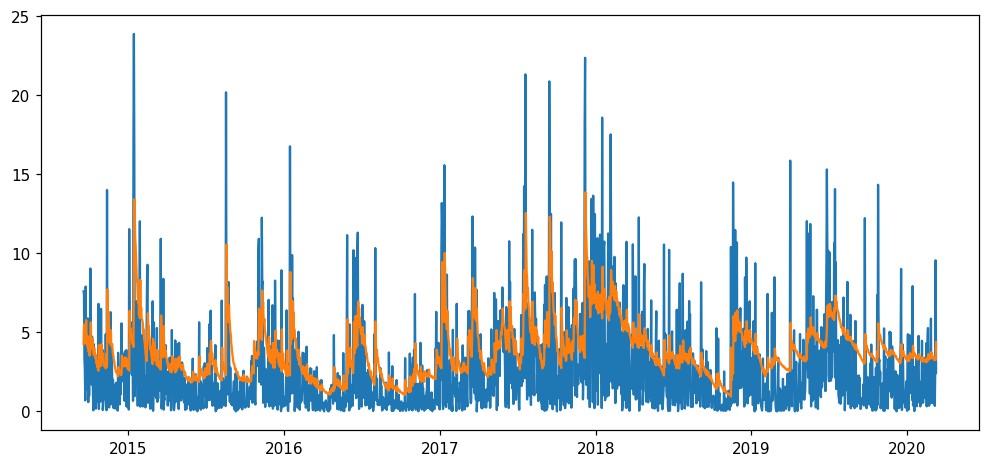

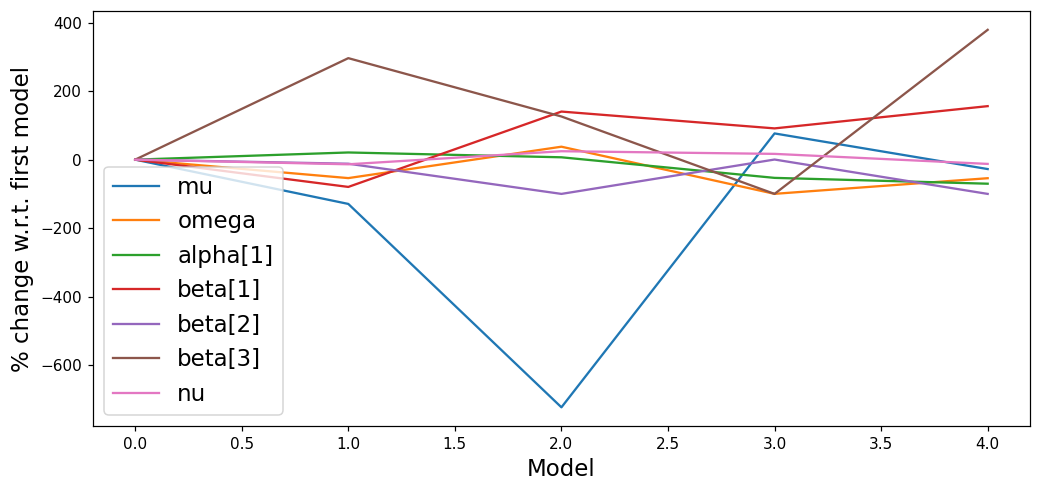

Date
2014-09-18    4.267239
2014-09-19    5.338649
2014-09-20    5.503998
2014-09-21    4.934279
2014-09-22    4.780175
                ...   
2020-03-05    3.247977
2020-03-06    3.411054
2020-03-07    3.286281
2020-03-08    3.268105
2020-03-09    4.391588
Name: cond_vol, Length: 2000, dtype: float64

In [24]:
#helper function to plot the parameter variability

def in_sample_window_fit(model, windows_days = 400, plot = True):
    
    n_time = len(train_set)//windows_days   
    cond_vol = []
    parameters = []
    for j in range(n_time):
       if j == 0:
            start = train_set.index[0]
            end = start + timedelta(days = windows_days)
            fitted_model = model.fit(first_obs = start, last_obs= end, disp = "off") 
            df = pd.DataFrame(fitted_model.params)
            df = df.T
            parameters.append(df)
            

       else:
            start = end 
            end = start + timedelta(days = windows_days)
            backcast = fitted_model.conditional_volatility.dropna().tail(1).values
            fitted_model = model.fit(first_obs = start, last_obs= end, disp = "off", backcast = backcast ) 
            df = pd.DataFrame(fitted_model.params)
            df = df.T
            parameters.append(df)
            
    
       fitted_model = model.fit(first_obs = start, last_obs= end, disp = "off" ) 
       cond_vol.append(fitted_model.conditional_volatility.dropna()) 
    vol_series = pd.concat(cond_vol)

    df_parameters = pd.concat(parameters)
    df_parameters = df_parameters.reset_index(drop = True)
    
    df_parameters_pct = df_parameters.copy()
    for i in df_parameters_pct.index:
        df_parameters_pct.loc[i] = (df_parameters_pct.loc[i] / df_parameters.loc[0] -1)*100
    #print(df_parameters)
    
    
    
    if plot:
        
        plt.plot(train_set.loc[train_set.index.isin(vol_series.index)].abs())
        plt.plot(vol_series)
        plt.show()

        plt.plot(df_parameters_pct)
        plt.legend(df_parameters_pct, fontsize = 15)
        plt.xlabel("Model", fontsize = 15)
        plt.ylabel("% change w.r.t. first model", fontsize = 15)
        #plt.title("Change of parameters relative to the first model")
        plt.show()
        
    return vol_series



in_sample_window_fit(garch_13)

In [25]:
#then we try to fit a model for each windows - to see how the performance change 

def in_sample_window_fit(model, windows_days = 1200, plot = True):
    aic_list, bic_list = [],[]
    n_time = len(train_set)//windows_days   
    cond_vol = []
    train_set_new = train_set[train_set.index.isin(train_real.index)]
    for j in range(n_time):
       if j == 0:
            start = train_set_new.index[0]
            end = start + timedelta(days = windows_days)
            fitted_model = model.fit(first_obs = start, last_obs= end, disp = "off") 
            print(fitted_model.summary())
    

       else:

            start = end 
            end = start + timedelta(days = windows_days)
            backcast = fitted_model.conditional_volatility.dropna().tail(1).values
            fitted_model = model.fit(first_obs = start, last_obs= end, disp = "off", backcast = backcast ) 
           
       aic_list.append(fitted_model.aic)
       bic_list.append(fitted_model.bic)
       cond_vol.append( fitted_model.conditional_volatility.dropna() ) 
    
    vol_series = pd.concat(cond_vol)
    aic = np.array(aic_list).mean()
    bic =  np.array(bic_list).mean()
    name = fitted_model.model.volatility
    distribution = fitted_model.model.distribution


    if plot:
          plt.plot(train_set.loc[train_set.index.isin(vol_series.index)].abs())
          plt.plot(vol_series)
          plt.show()

    return f"{name}", f"{distribution}", vol_series, aic, bic



#we create a tab that select the best models for each columns 

def create_tab_insample_variation(list_models, windows_days = 400):
    df = pd.DataFrame(columns = ["Model", "Distribution", "Proxy MSE", "Proxy MAE", "Intra-1m MSE", "Intra-1m MAE", "Intra-1h MSE", "Intra-1h MAE"], index = [i for i in range(len(list_models))])
    series_list = []
    for j, m in enumerate(list_models):

        name, dist,series, aic, bic = in_sample_window_fit(m, windows_days, plot = False)
    
        df.loc[j, "Model"] = name
        df.loc[j, "Distribution"] = dist
        df.loc[j, "AIC"] = round(aic,1)
        df.loc[j, "BIC"] = round(bic,1)

        if j == 0:
             
              real_data = perc_r.loc[perc_r.index.isin(series.index)].abs().reset_index().Close
              minute = remove_outliers(train_real,2, 0.5)
              intra_m = minute.loc[minute.index.isin(series.index)].reset_index().ret 
              intra_h = train_real_1h.loc[train_real_1h.index.isin(series.index)].reset_index().ret
             
        series = series[series.index.isin(train_real.index)]
        series_list.append(series)
        series = series.reset_index()["cond_vol"]
        
        df.loc[j,"Proxy MAE"] = round(MAE(series, real_data),3)
        df.loc[j,"Proxy MSE"] = round(MSE(series, real_data),3)
      
        df.loc[j, "Intra-1h MSE"] = round(MSE(series, intra_h),3)
        df.loc[j, "Intra-1h MAE"] = round(MAE(series, intra_h),3)
     
     
    return df, series_list 


garch_42 = arch.arch_model(perc_r, vol="GARCH", p=4, q=2, dist = "Normal")
garch_13_t = arch.arch_model(perc_r,vol="GARCH", p=1, q=3, dist = "StudentsT")
garch_11_t = arch.arch_model(perc_r, vol="GARCH", p=1, q=1, dist = "StudentsT")
garch_13_st = arch.arch_model(perc_r, vol="GARCH", p=1, q=3, dist = "SkewStudent")
garch_11_st = arch.arch_model(perc_r, vol="GARCH", p=1, q=1, dist = "SkewStudent")
eg_51 = arch.arch_model(perc_r, vol = "EGARCH" ,p = 5, o = 1,q=1, dist = "Normal")
eg_41 = arch.arch_model(perc_r, vol = "EGARCH" ,p = 4, o = 1, q=1,dist = "Normal")
eg_21_t = arch.arch_model(perc_r, vol = "EGARCH" ,p = 2, o = 1,q=1, dist = "StudentsT")
eg_11_t = arch.arch_model(perc_r, vol = "EGARCH" ,p = 1, o = 1, q=1,dist = "StudentsT")
eg_21_st = arch.arch_model(perc_r, vol = "EGARCH" ,p = 2, o = 1, q=1,dist = "SkewStudent")
eg_11_st = arch.arch_model(perc_r, vol = "EGARCH" ,p = 1, o = 1,q=1, dist = "SkewStudent")



list_models= [garch_42, garch_13_t, garch_11_t, garch_13_st, garch_11_st, eg_51, eg_41, eg_21_t, eg_11_t, eg_21_st, eg_11_st]



def bestmodels_in(tab):
    ind = []
    col = ["AIC", "BIC", "Proxy MSE", "Proxy MAE", 
           "Intra-1h MSE", "Intra-1h MAE"]
    col_ret = ['Model', 'Distribution', "AIC", "BIC", 'Proxy MSE', 'Proxy MAE','Intra-1h MSE', 'Intra-1h MAE']
    for c in col:
        
        index =  tab.loc[:,c].astype("float64").argmin()
       
        # if index not in ind:
        ind.append(index)
    
    best = tab.iloc[ind,0:]
    best2 = best.loc[:,col_ret]
    #best2 = best2[col].round(3)
    return best2



tab_in, s = create_tab_insample_variation(list_models)
tab_in = bestmodels_in(tab_in)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -931.372
Distribution:                  Normal   AIC:                           1878.74
Method:            Maximum Likelihood   BIC:                           1910.67
                                        No. Observations:                  400
Date:                Sun, Jun 19 2022   Df Residuals:                      399
Time:                        14:57:59   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0240      0.132      0.183      0.855 [ -0.234,  0.28

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -896.924
Distribution:                  Normal   AIC:                           1809.85
Method:            Maximum Likelihood   BIC:                           1841.78
                                        No. Observations:                  400
Date:                Sun, Jun 19 2022   Df Residuals:                      399
Time:                        14:58:02   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.4243  2.420e-03    175.370      0.000 [  0.420,  0.42

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -840.961
Distribution:      Standardized Student's t   AIC:                           1693.92
Method:                  Maximum Likelihood   BIC:                           1717.87
                                              No. Observations:                  400
Date:                      Sun, Jun 19 2022   Df Residuals:                      399
Time:                              14:58:04   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -838.802
Distribution:      Standardized Skew Student's t   AIC:                           1693.60
Method:                       Maximum Likelihood   BIC:                           1725.54
                                                   No. Observations:                  400
Date:                           Sun, Jun 19 2022   Df Residuals:                      399
Time:                                   14:58:04   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

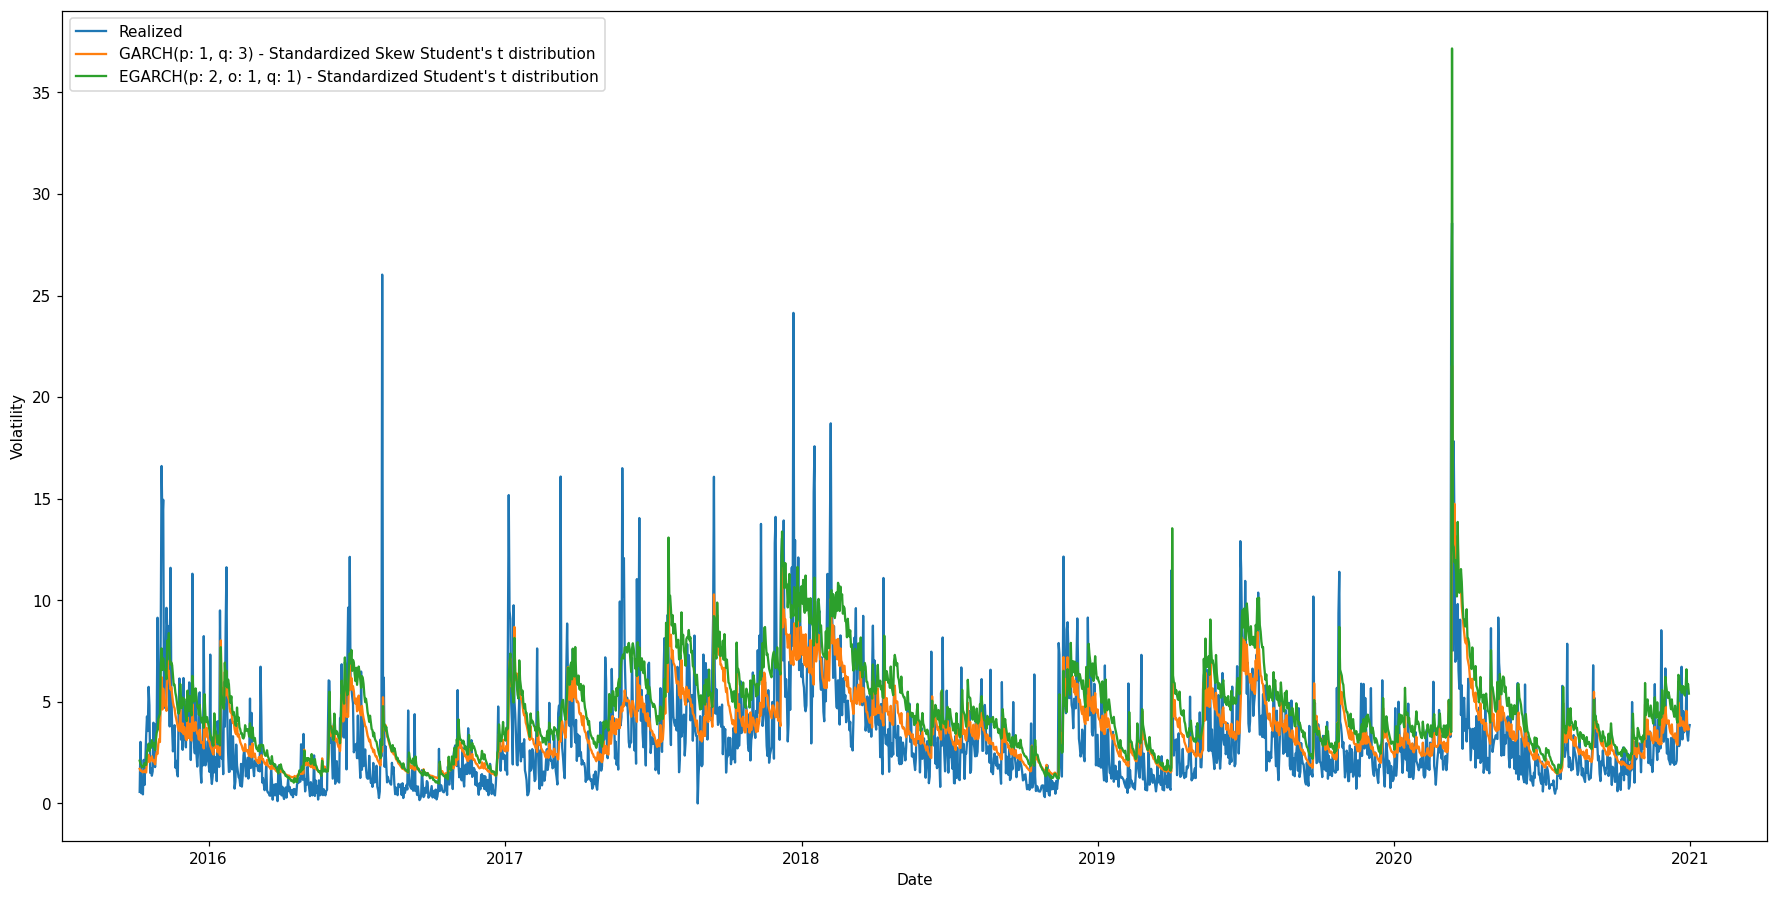

In [26]:
#confront fit best aic vs best loss 
plt.rcParams["figure.figsize"] = (20,10)

def confront_insample_model(model1, model2):
    fit_bestaic =  model1.fit(first_obs = train_set.index[0], last_obs= train_set.index[-1], disp = "off" )                                                                                                                 
    fitted_bestaic = fit_bestaic.conditional_volatility
    fit_garch = model2.fit(first_obs = train_set.index[0], last_obs= train_set.index[-1], disp = "off" )
    fitted_garch = fit_garch.conditional_volatility
    realized = train_real_1h
    plt.plot(realized, label = "Realized")
    plt.plot(fitted_garch.loc[fitted_garch.index.isin(realized.index)], label = f"{model2.volatility} - {model2.distribution}")
    plt.plot(fitted_bestaic.loc[fitted_bestaic.index.isin(realized.index)], label = f"{model1.volatility} - {model1.distribution}")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Volatility")
   #plt.savefig("Confrontinsample.png", dpi = 120, bbox_inches='tight' )
   #files.download("Confrontinsample.png")
    plt.show()


confront_insample_model(eg_21_t, garch_13_st )